# Step 0: Generation of MISO-1 with MISO (optional) 
This section is optional since we make MISO-1 available directly. This code for MISO can be used to generate a custom dataset if the user wishes. 
* [X] navigate to `run_scripts/run_controls.sh` and edit any slurm preamble inputs for your system + system-specific unix commands (e.g. conda environment statements
* [X] Navigate to the section where it says "MODIFY" and select the scenario (i.e. `partition`) to generate it. Run all 6 scenarios.
* `partition`: 
  * {distribution_shifted_pixels
  * extreme_value_pixels
  * extreme_value_superpixels
  * guilty_superpixels
  * morphological_differences
  * fractal_morphologies}
* Note: this will generate both the train and test datasets (fairly small dataset size)

# Step 1: Patching MISO-1 & MISO-2
* [X] navigate to `run_scripts/run_patch.sh` and edit any slurm preamble inputs for your system + system-specific unix commands (e.g. conda environment statements)
* [X] run `sbatch run_scripts/run_patch.sh` for all 6 scenarios (i.e. `cache_name`) and `study_arms` to get patch datasets for training and testing:
* `study_arm`: {train, test, both}
* `cache_name`:
  * {distribution_shifted_pixels
  * extreme_value_pixels
  * extreme_value_superpixels
  * guilty_superpixels
  * morphological_differences
  * fractal_morphologies
  * morphological_differences_superpixels} 
 * Note: we make the study_arm a parameter here since the number of patches generated is approximately 100K. We realize the number of items in filesystems can be maxed out (as opposed to actual storage), so we recommmend toggle this as needed while you train models on specific parititons, delete patch datasets of no use, and generate more as needed
 * Note 2: "morphological_differences_superpixels" is an alias for MISO-2

# Step 2: Training 
* [X] navigate to `run_scripts/run_train.sh` and edit any slurm preamble inputs for your system + system-specific unix commands (e.g. conda environment statements)
* [X] run `sbatch run_scripts/run_train.sh` for all 12 models (2 architectures [i.e. `model_class`] x 6 scenarios): 
* `model_class`: {VGG19, VGG_att}
* `scenario`:
  * {distribution_shifted_pixels
  * extreme_value_pixels
  * extreme_value_superpixels
  * guilty_superpixels
  * morphological_differences
  * fractal_morphologies
  * morphological_differences_superpixels}

# Step 3: Prediction
* [X] navigate to `run_scripts/run_predict_saliency.sh` and edit any slurm preamble inputs for your system + system-specific unix commands (e.g. conda environment statements)
* [X] run `run_scripts/run_predict_saliency.sh` for all 12 models (2 architectures [i.e. `model`] x 6 scenarios): 
* `model`: {VGG19, VGG_att}
* `scenario`:
  * {distribution_shifted_pixels
  * extreme_value_pixels
  * extreme_value_superpixels
  * guilty_superpixels
  * morphological_differences
  * fractal_morphologies,
  * morphological_differences_superpixels}


# Step 4: Explanation evaluation via Prediction Report Cards
After all the above jobs are run, we can generate performance statistics and take a look at local explanations that are illustrative of average test set performance.

### Setup for model performance and interpretation

In [ ]:
import pickle
import utils
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from scipy.signal import medfilt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision

from dataloader import DataLoader
from train import Flatten

from utils import serialize, deserialize, count_files #image_patch_summary, image_patch_pred_map, plot_roc_prc # should probably move serialize and de- to utils
from saliency import create_prediction_reportcard # show_saliency_maps, stitch_saliency, 

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
sns.set()
%reload_ext autoreload

In [3]:
USE_GPU = False
dtype = torch.float32    

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [4]:
patch_root = "/oak/stanford/groups/paragm/gautam/syncontrols/patches/1-channel"
patch_tail = "96-patchsize/none-filtered/train"
figure_path = "figs" # make sure you create a "figs" folder

### Report Card helper functions

In [5]:
from analysis import log_performance, print_train_stats, report_card

In [6]:
filtration = "none"

# Scenario (a) - Extreme Value Pixels (EVP)

### Background-preserved experiments

`Check training labels`

In [7]:
scenario = "extreme_value_pixels"
labeling = "inheritance"
print_train_stats(scenario, filter_toggle=filtration)

Train dataset
{'reg57': 1, 'reg85': 1, 'reg25': 1, 'reg36': 0, 'reg12': 0, 'reg23': 1, 'reg5': 1, 'reg3': 1, 'reg72': 0, 'reg70': 0, 'reg2': 0, 'reg41': 1, 'reg71': 1, 'reg28': 0, 'reg52': 0, 'reg19': 1, 'reg43': 1, 'reg91': 1, 'reg60': 0, 'reg59': 1, 'reg78': 0, 'reg21': 1, 'reg30': 0, 'reg17': 1, 'reg9': 1, 'reg7': 1, 'reg10': 0, 'reg34': 0, 'reg58': 0, 'reg42': 0, 'reg87': 1, 'reg83': 1, 'reg51': 1, 'reg75': 1, 'reg49': 1, 'reg63': 1, 'reg79': 1, 'reg54': 0, 'reg50': 0, 'reg6': 0, 'reg27': 1, 'reg33': 1, 'reg32': 0, 'reg62': 0, 'reg81': 1, 'reg96': 0, 'reg64': 0, 'reg61': 1, 'reg35': 1, 'reg56': 0, 'reg77': 1, 'reg31': 1, 'reg93': 1, 'reg11': 1, 'reg53': 1, 'reg39': 1, 'reg26': 0, 'reg1': 1, 'reg88': 0, 'reg45': 1, 'reg80': 0, 'reg16': 0, 'reg37': 1, 'reg92': 0, 'reg13': 1, 'reg48': 0, 'reg68': 0, 'reg14': 0, 'reg66': 0, 'reg76': 0, 'reg22': 0, 'reg47': 1, 'reg94': 0, 'reg46': 0, 'reg29': 1, 'reg24': 0, 'reg67': 1, 'reg18': 0, 'reg84': 0, 'reg86': 0, 'reg38': 0, 'reg90': 0, 'reg44':

`VGG-19 Report Card`

Test dataset:
{'reg42': 0, 'reg53': 1, 'reg69': 1, 'reg76': 0, 'reg40': 0, 'reg18': 0, 'reg78': 0, 'reg12': 0, 'reg72': 0, 'reg87': 1, 'reg52': 0, 'reg23': 1, 'reg44': 0, 'reg11': 1, 'reg29': 1, 'reg63': 1, 'reg21': 1, 'reg10': 0, 'reg26': 0, 'reg59': 1, 'reg90': 0, 'reg36': 0, 'reg58': 0, 'reg94': 0, 'reg68': 0, 'reg79': 1, 'reg80': 0, 'reg43': 1, 'reg57': 1, 'reg25': 1, 'reg27': 1, 'reg83': 1, 'reg17': 1, 'reg74': 0, 'reg91': 1, 'reg39': 1, 'reg4': 0, 'reg50': 0, 'reg81': 1, 'reg64': 0, 'reg22': 0, 'reg15': 1, 'reg35': 1, 'reg86': 0, 'reg51': 1, 'reg82': 0, 'reg48': 0, 'reg93': 1, 'reg88': 0, 'reg46': 0, 'reg55': 1, 'reg2': 0, 'reg77': 1, 'reg71': 1, 'reg9': 1, 'reg13': 1, 'reg32': 0, 'reg65': 1, 'reg84': 0, 'reg47': 1, 'reg6': 0, 'reg60': 0, 'reg66': 0, 'reg56': 0, 'reg16': 0, 'reg38': 0, 'reg73': 1, 'reg31': 1, 'reg95': 1, 'reg5': 1, 'reg19': 1, 'reg24': 0, 'reg30': 0, 'reg75': 1, 'reg37': 1, 'reg67': 1, 'reg20': 0, 'reg92': 0, 'reg28': 0, 'reg54': 0, 'reg1': 1, 'reg70': 0, 'reg89'

/home/groups/plevriti/gautam/codex_analysis/codex-analysis/code/saliency.py:664: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  score = rule(a, b)


	 2 reg69 label= 1
raw gt: [[ 0.44851345  0.44851345  0.44976128 ... -0.5        -0.5
   0.        ]
 [ 0.44851345  0.89702691  0.89827474 ... -0.25303819 -1.
  -0.5       ]
 [ 0.45068359  0.89919705  0.8999566  ... -0.25303819 -1.
  -0.5       ]
 ...
 [-0.5        -1.         -1.         ... -1.         -1.
  -0.5       ]
 [-0.5        -1.         -1.         ... -1.         -1.
  -0.5       ]
 [ 0.         -0.5        -0.5        ... -0.5        -0.5
  -0.5       ]]
preview of maps
raw sal: [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
bin sal: [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
gt: [[0 0 0 ... 0 0 0]
 [0 1 1 ... 0 0 0]
 [0 1 1 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
ssm/sam dice
ssm/sam jaccard
ssm/sam overlap
ssm/sam sensitivity
ssm/sam specificty
ssm/sam d

/home/groups/plevriti/gautam/codex_analysis/codex-analysis/code/saliency.py:664: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  score = rule(a, b)


	 45 reg82 label= 0
	 46 reg48 label= 0
	 47 reg93 label= 1
ssm/sam dice
ssm/sam jaccard
ssm/sam overlap
ssm/sam sensitivity
ssm/sam specificty
ssm/sam difference
ssm/sam scagnostics_cos
ssm/sam mae
ssm/sam f-measure
ssm/sam s-measure
ssm/sam e-measure
ssm/sam ssim
	 48 reg88 label= 0
	 49 reg46 label= 0
	 50 reg55 label= 1
	Completed analyses for 50 control images
ssm/sam dice
ssm/sam jaccard
ssm/sam overlap
ssm/sam sensitivity
ssm/sam specificty
ssm/sam difference
ssm/sam scagnostics_cos
ssm/sam mae
ssm/sam f-measure
ssm/sam s-measure
ssm/sam e-measure
ssm/sam ssim
	 51 reg2 label= 0
	 52 reg77 label= 1
ssm/sam dice
ssm/sam jaccard
ssm/sam overlap
ssm/sam sensitivity
ssm/sam specificty
ssm/sam difference
ssm/sam scagnostics_cos
ssm/sam mae
ssm/sam f-measure
ssm/sam s-measure
ssm/sam e-measure
ssm/sam ssim
	 53 reg71 label= 1
ssm/sam dice
ssm/sam jaccard
ssm/sam overlap
ssm/sam sensitivity
ssm/sam specificty
ssm/sam difference
ssm/sam scagnostics_cos
ssm/sam mae
ssm/sam f-measure
ssm/

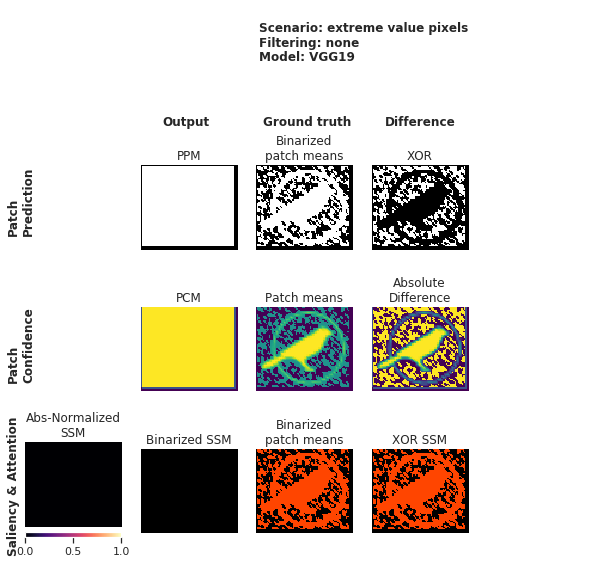

In [8]:
model = "VGG19"
example_1 = "reg35-canary-hot-test.npy" 
example_0 = "reg36-canary-cold-test.npy" 
scores = report_card(scenario, model, example_1, example_0, filter_toggle=filtration)

In [9]:
experiment = model +"_"+ scenario +"_"+ filtration +"_"+ labeling
log_performance(scores, experiment, overwrite_flag=True)
df = pd.read_csv("outputs/master_scores.csv")
df.head()

Score CSV file detected!
Score DICT file detected!
Overwrite flag is True... writing to master_scores.csv!
['VGG19_extreme_value_pixels_none_inheritance', 0.5, 0.75, 0.5, 'topk_majority accuracy = 0.500', 'all_max accuracy = 0.500', 'all_majority accuracy = 0.500', 'all_weighted_majority accuracy = 0.500', 'all_caucus_max accuracy = 0.500', 'all_caucus_majority accuracy = 0.500', 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.75, 0.75, 0.6666666666666667, 0.625, 0.6270833333333334, 0.6059027777777778, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 'Average test ppm_confidence-mae (CI) = 0.223 (0.014)', 'Average test ppm_confidence-ssim (CI) = 0.221 (0.038)', 'Average test ppm_values-dice (CI) = 0.444 (0.089)', 'Average test ppm_values-jaccard (CI) = 0.402 (0.082)', 'Average test ppm_values-overlap (CI) = 0.500 (0.100)', 'Average test ppm_values-sensitivity (CI) = 0.500 (0.100)', 'Average test ppm_values-specificty (CI) = 0.674 (0.047)', 'Average test ppm_values-difference (CI) = 0.463 (0.061)', 'Average test ppm_valu

,experiment,patch_auroc,patch_auprc,patch_ap,acc_topk_maj,acc_all_max,acc_all_maj,acc_all_weight,acc_all_caucus_max,acc_all_caucus_maj,...,sam_overlap,sam_sens,sam_spec,sam_diff,sam_scagcos,sam_mae,sam_f,sam_s,sam_e,sam_ssim
0,VGG_att_extreme_value_pixels_background_inheri...,1.0,1.000000,1.000000,1.0,0.5,0.76,0.5,0.646,0.667,...,0.749 (0.122),0.433 (0.123),0.985 (0.009),0.327 (0.067),0.361 (0.111),31.414 (4.148),0.489 (0.102),0.003 (0.004),0.542 (0.046),0.227 (0.061)
1,VGG19_extreme_value_pixels_background_inheritance,1.0,1.000000,1.000000,1.0,0.5,0.76,0.5,0.646,0.667,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,VGG19_distribution_shifted_pixels_background_i...,0.5,0.750014,0.500028,0.5,0.5,0.50,0.5,0.500,0.500,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,VGG_att_distribution_shifted_pixels_background...,1.0,1.000000,1.000000,1.0,0.5,0.75,0.5,0.688,0.667,...,0.930 (0.068),0.493 (0.114),0.990 (0.005),0.285 (0.066),0.170 (0.068),0.831 (0.112),0.585 (0.098),0.541 (0.016),0.610 (0.045),0.412 (0.054)
4,VGG19_distribution_shifted_pixels_none_inherit...,0.5,0.750000,0.500000,0.5,0.5,0.50,0.5,0.500,0.500,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


`VGG-Att Report Card`

Test dataset:
{'reg42': 0, 'reg53': 1, 'reg69': 1, 'reg76': 0, 'reg40': 0, 'reg18': 0, 'reg78': 0, 'reg12': 0, 'reg72': 0, 'reg87': 1, 'reg52': 0, 'reg23': 1, 'reg44': 0, 'reg11': 1, 'reg29': 1, 'reg63': 1, 'reg21': 1, 'reg10': 0, 'reg26': 0, 'reg59': 1, 'reg90': 0, 'reg36': 0, 'reg58': 0, 'reg94': 0, 'reg68': 0, 'reg79': 1, 'reg80': 0, 'reg43': 1, 'reg57': 1, 'reg25': 1, 'reg27': 1, 'reg83': 1, 'reg17': 1, 'reg74': 0, 'reg91': 1, 'reg39': 1, 'reg4': 0, 'reg50': 0, 'reg81': 1, 'reg64': 0, 'reg22': 0, 'reg15': 1, 'reg35': 1, 'reg86': 0, 'reg51': 1, 'reg82': 0, 'reg48': 0, 'reg93': 1, 'reg88': 0, 'reg46': 0, 'reg55': 1, 'reg2': 0, 'reg77': 1, 'reg71': 1, 'reg9': 1, 'reg13': 1, 'reg32': 0, 'reg65': 1, 'reg84': 0, 'reg47': 1, 'reg6': 0, 'reg60': 0, 'reg66': 0, 'reg56': 0, 'reg16': 0, 'reg38': 0, 'reg73': 1, 'reg31': 1, 'reg95': 1, 'reg5': 1, 'reg19': 1, 'reg24': 0, 'reg30': 0, 'reg75': 1, 'reg37': 1, 'reg67': 1, 'reg20': 0, 'reg92': 0, 'reg28': 0, 'reg54': 0, 'reg1': 1, 'reg70': 0, 'reg89'

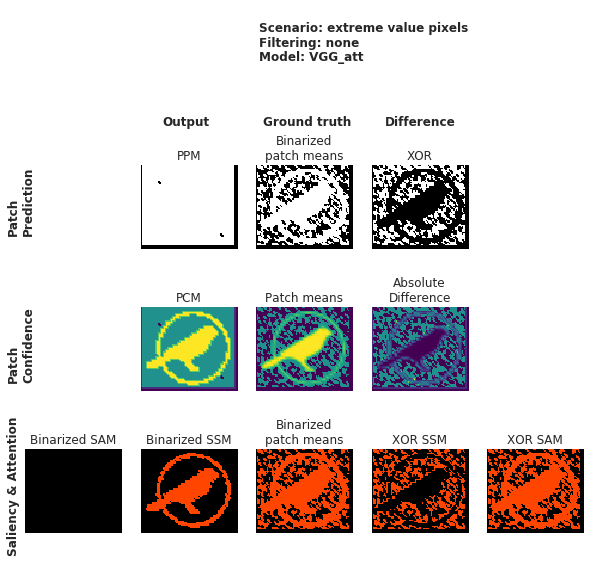

In [10]:
model = "VGG_att"
example_1 = "reg35-canary-hot-test.npy" 
example_0 = "reg36-canary-cold-test.npy"
scores = report_card(scenario, model, example_1, example_0, filter_toggle=filtration)

In [11]:
experiment = model +"_"+ scenario +"_"+ filtration +"_"+ labeling
log_performance(scores, experiment, overwrite_flag=True)
df = pd.read_csv("outputs/master_scores.csv")
df.head()

Score CSV file detected!
Score DICT file detected!
Overwrite flag is True... writing to master_scores.csv!
['VGG_att_extreme_value_pixels_none_inheritance', 0.8731820420925858, 0.8858302805005942, 0.8855752003567007, 'topk_majority accuracy = 1.000', 'all_max accuracy = 0.500', 'all_majority accuracy = 0.979', 'all_weighted_majority accuracy = 0.500', 'all_caucus_max accuracy = 0.562', 'all_caucus_majority accuracy = 0.917', 1.0, 1.0, 0.8913966049382717, 0.86474609375, 0.8348958333333334, 0.8454258294753086, 1.0, 1.0, 0.9057964958814642, 0.8659740002980971, 0.8383754785270143, 0.8336025007485375, 1.0, 1.0, 0.9060826956968178, 0.8663305249351455, 0.838738026261921, 0.8339512618781472, 'Average test ppm_confidence-mae (CI) = 0.341 (0.039)', 'Average test ppm_confidence-ssim (CI) = 0.299 (0.059)', 'Average test ppm_values-dice (CI) = 0.811 (0.031)', 'Average test ppm_values-jaccard (CI) = 0.705 (0.036)', 'Average test ppm_values-overlap (CI) = 0.961 (0.010)', 'Average test ppm_values-sens

,experiment,patch_auroc,patch_auprc,patch_ap,acc_topk_maj,acc_all_max,acc_all_maj,acc_all_weight,acc_all_caucus_max,acc_all_caucus_maj,...,sam_overlap,sam_sens,sam_spec,sam_diff,sam_scagcos,sam_mae,sam_f,sam_s,sam_e,sam_ssim
0,VGG_att_extreme_value_pixels_background_inheri...,1.0,1.000000,1.000000,1.0,0.5,0.76,0.5,0.646,0.667,...,0.749 (0.122),0.433 (0.123),0.985 (0.009),0.327 (0.067),0.361 (0.111),31.414 (4.148),0.489 (0.102),0.003 (0.004),0.542 (0.046),0.227 (0.061)
1,VGG19_extreme_value_pixels_background_inheritance,1.0,1.000000,1.000000,1.0,0.5,0.76,0.5,0.646,0.667,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,VGG19_distribution_shifted_pixels_background_i...,0.5,0.750014,0.500028,0.5,0.5,0.50,0.5,0.500,0.500,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,VGG_att_distribution_shifted_pixels_background...,1.0,1.000000,1.000000,1.0,0.5,0.75,0.5,0.688,0.667,...,0.930 (0.068),0.493 (0.114),0.990 (0.005),0.285 (0.066),0.170 (0.068),0.831 (0.112),0.585 (0.098),0.541 (0.016),0.610 (0.045),0.412 (0.054)
4,VGG19_distribution_shifted_pixels_none_inherit...,0.5,0.750000,0.500000,0.5,0.5,0.50,0.5,0.500,0.500,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Scenario (b) - Distribution-Shifted Pixels (DSP)

### Background-preserved experiments

`Check training labels`

In [20]:
scenario = "distribution_shifted_pixels"
labeling = "inheritance"
print_train_stats(scenario, filter_toggle=filtration)

Train dataset
{'reg32': 0, 'reg55': 1, 'reg26': 0, 'reg3': 1, 'reg53': 1, 'reg23': 1, 'reg30': 0, 'reg33': 1, 'reg67': 1, 'reg83': 1, 'reg88': 0, 'reg36': 0, 'reg29': 1, 'reg94': 0, 'reg14': 0, 'reg7': 1, 'reg40': 0, 'reg8': 0, 'reg61': 1, 'reg72': 0, 'reg68': 0, 'reg82': 0, 'reg79': 1, 'reg96': 0, 'reg6': 0, 'reg48': 0, 'reg49': 1, 'reg86': 0, 'reg92': 0, 'reg89': 1, 'reg54': 0, 'reg71': 1, 'reg46': 0, 'reg37': 1, 'reg60': 0, 'reg10': 0, 'reg13': 1, 'reg73': 1, 'reg74': 0, 'reg25': 1, 'reg4': 0, 'reg91': 1, 'reg9': 1, 'reg65': 1, 'reg42': 0, 'reg35': 1, 'reg21': 1, 'reg52': 0, 'reg12': 0, 'reg56': 0, 'reg50': 0, 'reg11': 1, 'reg93': 1, 'reg59': 1, 'reg85': 1, 'reg34': 0, 'reg87': 1, 'reg5': 1, 'reg39': 1, 'reg43': 1, 'reg84': 0, 'reg28': 0, 'reg64': 0, 'reg75': 1, 'reg27': 1, 'reg80': 0, 'reg22': 0, 'reg44': 0, 'reg63': 1, 'reg51': 1, 'reg57': 1, 'reg90': 0, 'reg95': 1, 'reg76': 0, 'reg70': 0, 'reg66': 0, 'reg81': 1, 'reg16': 0, 'reg69': 1, 'reg20': 0, 'reg38': 0, 'reg17': 1, 'reg31':

`VGG-19 Report Card`

Test dataset:
{'reg11': 1, 'reg64': 0, 'reg53': 1, 'reg68': 0, 'reg30': 0, 'reg9': 1, 'reg39': 1, 'reg22': 0, 'reg1': 1, 'reg76': 0, 'reg42': 0, 'reg24': 0, 'reg41': 1, 'reg58': 0, 'reg10': 0, 'reg34': 0, 'reg12': 0, 'reg78': 0, 'reg66': 0, 'reg52': 0, 'reg31': 1, 'reg3': 1, 'reg60': 0, 'reg71': 1, 'reg74': 0, 'reg57': 1, 'reg19': 1, 'reg14': 0, 'reg8': 0, 'reg47': 1, 'reg2': 0, 'reg69': 1, 'reg28': 0, 'reg13': 1, 'reg70': 0, 'reg5': 1, 'reg87': 1, 'reg83': 1, 'reg81': 1, 'reg38': 0, 'reg35': 1, 'reg92': 0, 'reg21': 1, 'reg32': 0, 'reg16': 0, 'reg79': 1, 'reg89': 1, 'reg56': 0, 'reg43': 1, 'reg94': 0, 'reg85': 1, 'reg72': 0, 'reg20': 0, 'reg18': 0, 'reg80': 0, 'reg50': 0, 'reg27': 1, 'reg49': 1, 'reg88': 0, 'reg67': 1, 'reg44': 0, 'reg15': 1, 'reg46': 0, 'reg7': 1, 'reg65': 1, 'reg90': 0, 'reg82': 0, 'reg55': 1, 'reg59': 1, 'reg84': 0, 'reg4': 0, 'reg54': 0, 'reg40': 0, 'reg29': 1, 'reg93': 1, 'reg23': 1, 'reg26': 0, 'reg33': 1, 'reg17': 1, 'reg91': 1, 'reg61': 1, 'reg6': 0, 'reg45': 1

/home/groups/plevriti/gautam/codex_analysis/codex-analysis/code/saliency.py:664: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  score = rule(a, b)


ssm/sam overlap
ssm/sam sensitivity
ssm/sam specificty
ssm/sam difference
ssm/sam scagnostics_cos
ssm/sam mae
ssm/sam f-measure
ssm/sam s-measure
ssm/sam e-measure
ssm/sam ssim
	 41 reg92 label= 0
	 42 reg21 label= 1
ssm/sam dice
ssm/sam jaccard
ssm/sam overlap
ssm/sam sensitivity
ssm/sam specificty
ssm/sam difference
ssm/sam scagnostics_cos
ssm/sam mae
ssm/sam f-measure
ssm/sam s-measure
ssm/sam e-measure
ssm/sam ssim
	 43 reg32 label= 0
	 44 reg16 label= 0
	 45 reg79 label= 1
ssm/sam dice
ssm/sam jaccard
ssm/sam overlap
ssm/sam sensitivity
ssm/sam specificty
ssm/sam difference
ssm/sam scagnostics_cos
ssm/sam mae
ssm/sam f-measure
ssm/sam s-measure
ssm/sam e-measure
ssm/sam ssim
	 46 reg89 label= 1
ssm/sam dice
ssm/sam jaccard
ssm/sam overlap
ssm/sam sensitivity
ssm/sam specificty
ssm/sam difference
ssm/sam scagnostics_cos
ssm/sam mae
ssm/sam f-measure
ssm/sam s-measure
ssm/sam e-measure
ssm/sam ssim
	 47 reg56 label= 0
	 48 reg43 label= 1
ssm/sam dice
ssm/sam jaccard
ssm/sam overlap


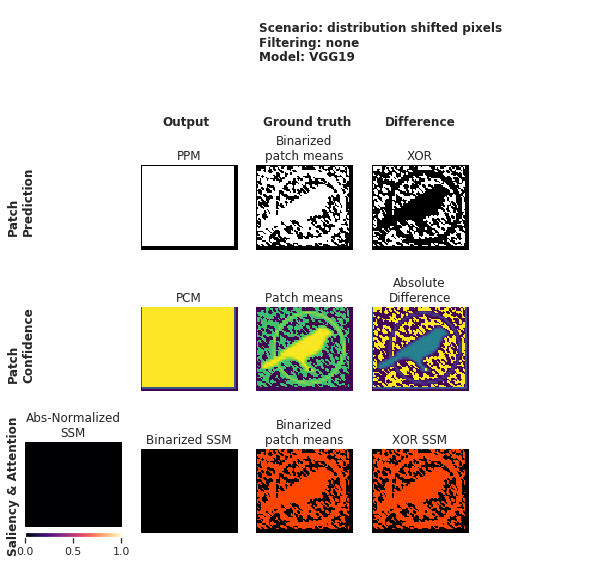

In [21]:
model = "VGG19"
example_1 = "reg83-canary-fuzzy_distrib-hot-test.npy" 
example_0 = "reg84-canary-fuzzy_distrib-cold-test.npy" 
scores = report_card(scenario, model, example_1, example_0, filter_toggle=filtration)

In [22]:
experiment = model +"_"+ scenario +"_"+ filtration +"_"+ labeling
log_performance(scores, experiment, overwrite_flag=True)
df = pd.read_csv("outputs/master_scores.csv")
df.head()

Score CSV file detected!
Score DICT file detected!
Overwrite flag is True... writing to master_scores.csv!
['VGG19_distribution_shifted_pixels_none_inheritance', 0.5, 0.75, 0.5, 'topk_majority accuracy = 0.500', 'all_max accuracy = 0.500', 'all_majority accuracy = 0.500', 'all_weighted_majority accuracy = 0.500', 'all_caucus_max accuracy = 0.500', 'all_caucus_majority accuracy = 0.500', 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.75, 0.75, 0.6666666666666667, 0.625, 0.6270833333333334, 0.6059027777777778, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 'Average test ppm_confidence-mae (CI) = 0.224 (0.007)', 'Average test ppm_confidence-ssim (CI) = 0.202 (0.047)', 'Average test ppm_values-dice (CI) = 0.443 (0.089)', 'Average test ppm_values-jaccard (CI) = 0.401 (0.082)', 'Average test ppm_values-overlap (CI) = 0.500 (0.100)', 'Average test ppm_values-sensitivity (CI) = 0.500 (0.100)', 'Average test ppm_values-specificty (CI) = 0.673 (0.047)', 'Average test ppm_values-difference (CI) = 0.463 (0.061)', 'Average test p

,experiment,patch_auroc,patch_auprc,patch_ap,acc_topk_maj,acc_all_max,acc_all_maj,acc_all_weight,acc_all_caucus_max,acc_all_caucus_maj,...,sam_overlap,sam_sens,sam_spec,sam_diff,sam_scagcos,sam_mae,sam_f,sam_s,sam_e,sam_ssim
0,VGG_att_extreme_value_pixels_background_inheri...,1.0,1.000000,1.000000,1.0,0.5,0.76,0.5,0.646,0.667,...,0.749 (0.122),0.433 (0.123),0.985 (0.009),0.327 (0.067),0.361 (0.111),31.414 (4.148),0.489 (0.102),0.003 (0.004),0.542 (0.046),0.227 (0.061)
1,VGG19_extreme_value_pixels_background_inheritance,1.0,1.000000,1.000000,1.0,0.5,0.76,0.5,0.646,0.667,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,VGG19_distribution_shifted_pixels_background_i...,0.5,0.750014,0.500028,0.5,0.5,0.50,0.5,0.500,0.500,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,VGG_att_distribution_shifted_pixels_background...,1.0,1.000000,1.000000,1.0,0.5,0.75,0.5,0.688,0.667,...,0.930 (0.068),0.493 (0.114),0.990 (0.005),0.285 (0.066),0.170 (0.068),0.831 (0.112),0.585 (0.098),0.541 (0.016),0.610 (0.045),0.412 (0.054)
4,VGG19_distribution_shifted_pixels_none_inherit...,0.5,0.750000,0.500000,0.5,0.5,0.50,0.5,0.500,0.500,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


`VGG-Att Report Card`

Test dataset:
{'reg11': 1, 'reg64': 0, 'reg53': 1, 'reg68': 0, 'reg30': 0, 'reg9': 1, 'reg39': 1, 'reg22': 0, 'reg1': 1, 'reg76': 0, 'reg42': 0, 'reg24': 0, 'reg41': 1, 'reg58': 0, 'reg10': 0, 'reg34': 0, 'reg12': 0, 'reg78': 0, 'reg66': 0, 'reg52': 0, 'reg31': 1, 'reg3': 1, 'reg60': 0, 'reg71': 1, 'reg74': 0, 'reg57': 1, 'reg19': 1, 'reg14': 0, 'reg8': 0, 'reg47': 1, 'reg2': 0, 'reg69': 1, 'reg28': 0, 'reg13': 1, 'reg70': 0, 'reg5': 1, 'reg87': 1, 'reg83': 1, 'reg81': 1, 'reg38': 0, 'reg35': 1, 'reg92': 0, 'reg21': 1, 'reg32': 0, 'reg16': 0, 'reg79': 1, 'reg89': 1, 'reg56': 0, 'reg43': 1, 'reg94': 0, 'reg85': 1, 'reg72': 0, 'reg20': 0, 'reg18': 0, 'reg80': 0, 'reg50': 0, 'reg27': 1, 'reg49': 1, 'reg88': 0, 'reg67': 1, 'reg44': 0, 'reg15': 1, 'reg46': 0, 'reg7': 1, 'reg65': 1, 'reg90': 0, 'reg82': 0, 'reg55': 1, 'reg59': 1, 'reg84': 0, 'reg4': 0, 'reg54': 0, 'reg40': 0, 'reg29': 1, 'reg93': 1, 'reg23': 1, 'reg26': 0, 'reg33': 1, 'reg17': 1, 'reg91': 1, 'reg61': 1, 'reg6': 0, 'reg45': 1

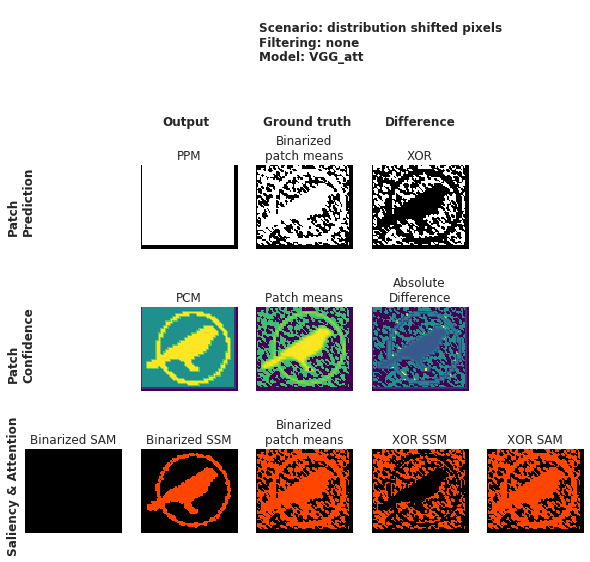

In [23]:
model = "VGG_att"
example_1 = "reg83-canary-fuzzy_distrib-hot-test.npy" 
example_0 = "reg84-canary-fuzzy_distrib-cold-test.npy" 
scores = report_card(scenario, model, example_1, example_0, filter_toggle=filtration, reduce_flag="manual")

In [24]:
experiment = model +"_"+ scenario +"_"+ filtration +"_"+ labeling
log_performance(scores, experiment, overwrite_flag=True)
df = pd.read_csv("outputs/master_scores.csv")
df.head()

Score CSV file detected!
Score DICT file detected!
Overwrite flag is True... writing to master_scores.csv!
['VGG_att_distribution_shifted_pixels_none_inheritance', 0.8741895405212906, 0.8866772609596821, 0.8863887708430668, 'topk_majority accuracy = 1.000', 'all_max accuracy = 0.500', 'all_majority accuracy = 0.979', 'all_weighted_majority accuracy = 0.500', 'all_caucus_max accuracy = 0.583', 'all_caucus_majority accuracy = 0.938', 1.0, 1.0, 0.9056712962962963, 0.8744574652777778, 0.8553993055555555, 0.8608820408950617, 1.0, 1.0, 0.9172505303883992, 0.8756723115636817, 0.8647263455242358, 0.856375951108575, 1.0, 1.0, 0.917507780857186, 0.8760054331835735, 0.8650166747347948, 0.8566635870588388, 'Average test ppm_confidence-mae (CI) = 0.346 (0.024)', 'Average test ppm_confidence-ssim (CI) = 0.371 (0.048)', 'Average test ppm_values-dice (CI) = 0.813 (0.030)', 'Average test ppm_values-jaccard (CI) = 0.707 (0.036)', 'Average test ppm_values-overlap (CI) = 0.961 (0.010)', 'Average test ppm_

,experiment,patch_auroc,patch_auprc,patch_ap,acc_topk_maj,acc_all_max,acc_all_maj,acc_all_weight,acc_all_caucus_max,acc_all_caucus_maj,...,sam_overlap,sam_sens,sam_spec,sam_diff,sam_scagcos,sam_mae,sam_f,sam_s,sam_e,sam_ssim
0,VGG_att_extreme_value_pixels_background_inheri...,1.0,1.000000,1.000000,1.0,0.5,0.76,0.5,0.646,0.667,...,0.749 (0.122),0.433 (0.123),0.985 (0.009),0.327 (0.067),0.361 (0.111),31.414 (4.148),0.489 (0.102),0.003 (0.004),0.542 (0.046),0.227 (0.061)
1,VGG19_extreme_value_pixels_background_inheritance,1.0,1.000000,1.000000,1.0,0.5,0.76,0.5,0.646,0.667,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,VGG19_distribution_shifted_pixels_background_i...,0.5,0.750014,0.500028,0.5,0.5,0.50,0.5,0.500,0.500,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,VGG_att_distribution_shifted_pixels_background...,1.0,1.000000,1.000000,1.0,0.5,0.75,0.5,0.688,0.667,...,0.930 (0.068),0.493 (0.114),0.990 (0.005),0.285 (0.066),0.170 (0.068),0.831 (0.112),0.585 (0.098),0.541 (0.016),0.610 (0.045),0.412 (0.054)
4,VGG19_distribution_shifted_pixels_none_inherit...,0.5,0.750000,0.500000,0.5,0.5,0.50,0.5,0.500,0.500,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Scenario (c) - Morphological Differences (MD)

### Background-preserved experiments

`Check training labels`

In [7]:
scenario = "morphological_differences"
labeling = "inheritance"
print_train_stats(scenario, filter_toggle=filtration)

Train dataset
{'reg42': 0, 'reg6': 0, 'reg100': 1, 'reg49': 0, 'reg86': 1, 'reg12': 0, 'reg57': 1, 'reg34': 0, 'reg5': 0, 'reg27': 0, 'reg102': 1, 'reg84': 1, 'reg39': 0, 'reg75': 1, 'reg51': 0, 'reg87': 1, 'reg80': 1, 'reg68': 1, 'reg47': 0, 'reg61': 1, 'reg82': 1, 'reg59': 1, 'reg79': 1, 'reg37': 0, 'reg64': 1, 'reg16': 0, 'reg70': 1, 'reg112': 1, 'reg21': 0, 'reg38': 0, 'reg40': 0, 'reg19': 0, 'reg85': 1, 'reg76': 1, 'reg26': 0, 'reg90': 1, 'reg99': 1, 'reg103': 1, 'reg24': 0, 'reg92': 1, 'reg50': 0, 'reg101': 1, 'reg43': 0, 'reg31': 0, 'reg58': 1, 'reg1': 0, 'reg10': 0, 'reg44': 0, 'reg13': 0, 'reg63': 1, 'reg89': 1, 'reg97': 1, 'reg48': 0, 'reg111': 1, 'reg69': 1, 'reg35': 0, 'reg105': 1, 'reg83': 1, 'reg11': 0, 'reg94': 1, 'reg55': 0, 'reg77': 1, 'reg29': 0, 'reg107': 1, 'reg96': 1, 'reg36': 0, 'reg88': 1, 'reg33': 0, 'reg109': 1, 'reg67': 1, 'reg71': 1, 'reg18': 0, 'reg52': 0, 'reg66': 1, 'reg104': 1, 'reg110': 1, 'reg54': 0, 'reg15': 0, 'reg93': 1, 'reg53': 0, 'reg23': 0, 'reg1

`VGG-19 Report Card`

Test dataset:
{'reg89': 1, 'reg109': 1, 'reg39': 0, 'reg68': 1, 'reg93': 1, 'reg81': 1, 'reg46': 0, 'reg36': 0, 'reg56': 0, 'reg91': 1, 'reg57': 1, 'reg38': 0, 'reg106': 1, 'reg22': 0, 'reg48': 0, 'reg65': 1, 'reg41': 0, 'reg21': 0, 'reg84': 1, 'reg72': 1, 'reg90': 1, 'reg70': 1, 'reg27': 0, 'reg108': 1, 'reg99': 1, 'reg103': 1, 'reg51': 0, 'reg52': 0, 'reg77': 1, 'reg14': 0, 'reg64': 1, 'reg49': 0, 'reg19': 0, 'reg31': 0, 'reg17': 0, 'reg67': 1, 'reg5': 0, 'reg85': 1, 'reg104': 1, 'reg53': 0, 'reg34': 0, 'reg28': 0, 'reg25': 0, 'reg15': 0, 'reg33': 0, 'reg42': 0, 'reg26': 0, 'reg45': 0, 'reg86': 1, 'reg95': 1, 'reg16': 0, 'reg8': 0, 'reg3': 0, 'reg73': 1, 'reg98': 1, 'reg92': 1, 'reg58': 1, 'reg75': 1, 'reg78': 1, 'reg60': 1, 'reg35': 0, 'reg24': 0, 'reg44': 0, 'reg7': 0, 'reg40': 0, 'reg61': 1, 'reg76': 1, 'reg107': 1, 'reg80': 1, 'reg87': 1, 'reg55': 0, 'reg30': 0, 'reg97': 1, 'reg11': 0, 'reg74': 1, 'reg37': 0, 'reg105': 1, 'reg79': 1, 'reg1': 0, 'reg29': 0, 'reg13': 0, 'reg20': 0,

/home/groups/plevriti/gautam/codex_analysis/codex-analysis/code/saliency.py:664: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  score = rule(a, b)


	 1 reg109 label= 1
raw gt: [[ 0.2515191   0.2515191   0.2484809  ... -0.5        -0.5
   0.        ]
 [ 0.2515191   0.50303819  0.5        ... -0.24913194 -1.
  -0.5       ]
 [ 0.24945747  0.50097656  0.49745009 ... -0.24913194 -1.
  -0.5       ]
 ...
 [-0.5        -0.25179036 -0.25179036 ... -0.24782986 -1.
  -0.5       ]
 [-0.5        -1.         -1.         ... -1.         -1.
  -0.5       ]
 [ 0.         -0.5        -0.5        ... -0.5        -0.5
  -0.5       ]]
preview of maps
raw sal: [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
bin sal: [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
gt: [[0 0 0 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
ssm/sam dice
ssm/sam jaccard
ssm/sam overlap
ssm/sam sensitivity
ssm/sam specificty
ssm/sam 

/home/groups/plevriti/gautam/codex_analysis/codex-analysis/code/saliency.py:664: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  score = rule(a, b)


	 60 reg35 label= 0
	Completed analyses for 60 control images
	 61 reg24 label= 0
	 62 reg44 label= 0
	 63 reg7 label= 0
	 64 reg40 label= 0
	 65 reg61 label= 1
ssm/sam dice
ssm/sam jaccard
ssm/sam overlap
ssm/sam sensitivity
ssm/sam specificty
ssm/sam difference
ssm/sam scagnostics_cos
ssm/sam mae
ssm/sam f-measure
ssm/sam s-measure
ssm/sam e-measure
ssm/sam ssim
	 66 reg76 label= 1
ssm/sam dice
ssm/sam jaccard
ssm/sam overlap
ssm/sam sensitivity
ssm/sam specificty
ssm/sam difference
ssm/sam scagnostics_cos
ssm/sam mae
ssm/sam f-measure
ssm/sam s-measure
ssm/sam e-measure
ssm/sam ssim
	 67 reg107 label= 1
ssm/sam dice
ssm/sam jaccard
ssm/sam overlap
ssm/sam sensitivity
ssm/sam specificty
ssm/sam difference
ssm/sam scagnostics_cos
ssm/sam mae
ssm/sam f-measure
ssm/sam s-measure
ssm/sam e-measure
ssm/sam ssim
	 68 reg80 label= 1
ssm/sam dice
ssm/sam jaccard
ssm/sam overlap
ssm/sam sensitivity
ssm/sam specificty
ssm/sam difference
ssm/sam scagnostics_cos
ssm/sam mae
ssm/sam f-measure
ssm

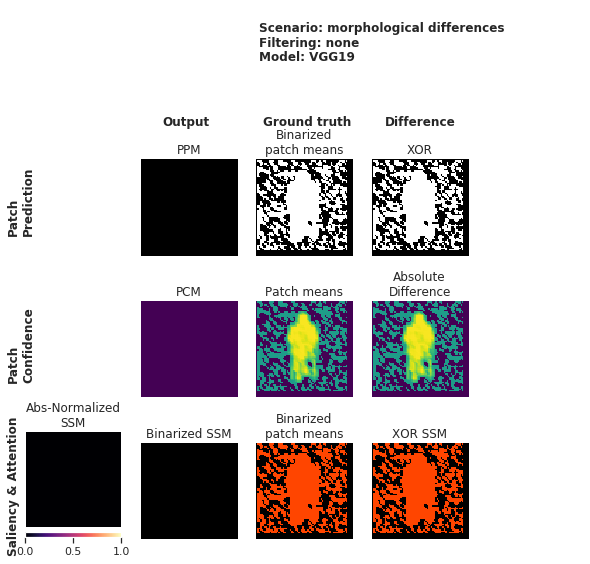

In [8]:
model = "VGG19"
example_1 = "reg78-bernie-etsy-fuzzy-hot-test.npy"
example_0 = "reg44-canary-fuzzy-hot-test.npy"
scores = report_card(scenario, model, example_1, example_0, filter_toggle=filtration)

In [9]:
experiment = model +"_"+ scenario +"_"+ filtration +"_"+ labeling
log_performance(scores, experiment, overwrite_flag=True)
df = pd.read_csv("outputs/master_scores.csv")
df.head()

Score CSV file detected!
Score DICT file detected!
Overwrite flag is True... writing to master_scores.csv!
['VGG19_morphological_differences_none_inheritance', 0.5, 0.7310968190509299, 0.46219363810185987, 'topk_majority accuracy = 0.500', 'all_max accuracy = 0.500', 'all_majority accuracy = 0.500', 'all_weighted_majority accuracy = 0.500', 'all_caucus_max accuracy = 0.500', 'all_caucus_majority accuracy = 0.500', 0.5, 0.5, 0.4623015873015873, 0.5, 0.5164285714285715, 0.5198412698412699, 0.75, 0.625, 0.5730242096945214, 0.5612722947344871, 0.5652682141314145, 0.5567461767579416, 0.5, 0.5, 0.4887881077155368, 0.4975582344451661, 0.5145531181838997, 0.5142691239925519, 'Average test ppm_confidence-mae (CI) = 0.369 (0.030)', 'Average test ppm_confidence-ssim (CI) = 0.064 (0.012)', 'Average test ppm_values-dice (CI) = 0.387 (0.072)', 'Average test ppm_values-jaccard (CI) = 0.316 (0.059)', 'Average test ppm_values-overlap (CI) = 0.500 (0.093)', 'Average test ppm_values-sensitivity (CI) = 0.

,experiment,patch_auroc,patch_auprc,patch_ap,acc_topk_maj,acc_all_max,acc_all_maj,acc_all_weight,acc_all_caucus_max,acc_all_caucus_maj,...,sam_overlap,sam_sens,sam_spec,sam_diff,sam_scagcos,sam_mae,sam_f,sam_s,sam_e,sam_ssim
0,VGG_att_extreme_value_pixels_background_inheri...,1.0,1.000000,1.000000,1.0,0.5,0.76,0.5,0.646,0.667,...,0.749 (0.122),0.433 (0.123),0.985 (0.009),0.327 (0.067),0.361 (0.111),31.414 (4.148),0.489 (0.102),0.003 (0.004),0.542 (0.046),0.227 (0.061)
1,VGG19_extreme_value_pixels_background_inheritance,1.0,1.000000,1.000000,1.0,0.5,0.76,0.5,0.646,0.667,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,VGG19_distribution_shifted_pixels_background_i...,0.5,0.750014,0.500028,0.5,0.5,0.50,0.5,0.500,0.500,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,VGG_att_distribution_shifted_pixels_background...,1.0,1.000000,1.000000,1.0,0.5,0.75,0.5,0.688,0.667,...,0.930 (0.068),0.493 (0.114),0.990 (0.005),0.285 (0.066),0.170 (0.068),0.831 (0.112),0.585 (0.098),0.541 (0.016),0.610 (0.045),0.412 (0.054)
4,VGG19_distribution_shifted_pixels_none_inherit...,0.5,0.750000,0.500000,0.5,0.5,0.50,0.5,0.500,0.500,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


`VGG-Att Report Card` (Run kills kernel easily on jupyter -- adding manual removal)

Test dataset:
{'reg89': 1, 'reg109': 1, 'reg39': 0, 'reg68': 1, 'reg93': 1, 'reg81': 1, 'reg46': 0, 'reg36': 0, 'reg56': 0, 'reg91': 1, 'reg57': 1, 'reg38': 0, 'reg106': 1, 'reg22': 0, 'reg48': 0, 'reg65': 1, 'reg41': 0, 'reg21': 0, 'reg84': 1, 'reg72': 1, 'reg90': 1, 'reg70': 1, 'reg27': 0, 'reg108': 1, 'reg99': 1, 'reg103': 1, 'reg51': 0, 'reg52': 0, 'reg77': 1, 'reg14': 0, 'reg64': 1, 'reg49': 0, 'reg19': 0, 'reg31': 0, 'reg17': 0, 'reg67': 1, 'reg5': 0, 'reg85': 1, 'reg104': 1, 'reg53': 0, 'reg34': 0, 'reg28': 0, 'reg25': 0, 'reg15': 0, 'reg33': 0, 'reg42': 0, 'reg26': 0, 'reg45': 0, 'reg86': 1, 'reg95': 1, 'reg16': 0, 'reg8': 0, 'reg3': 0, 'reg73': 1, 'reg98': 1, 'reg92': 1, 'reg58': 1, 'reg75': 1, 'reg78': 1, 'reg60': 1, 'reg35': 0, 'reg24': 0, 'reg44': 0, 'reg7': 0, 'reg40': 0, 'reg61': 1, 'reg76': 1, 'reg107': 1, 'reg80': 1, 'reg87': 1, 'reg55': 0, 'reg30': 0, 'reg97': 1, 'reg11': 0, 'reg74': 1, 'reg37': 0, 'reg105': 1, 'reg79': 1, 'reg1': 0, 'reg29': 0, 'reg13': 0, 'reg20': 0,

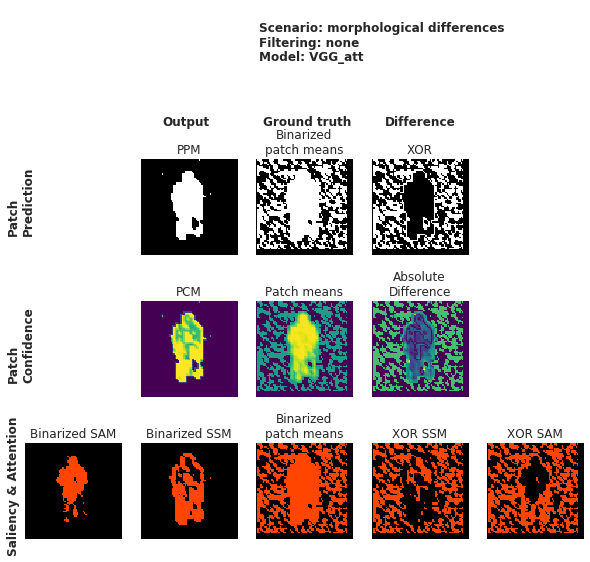

In [10]:
model = "VGG_att"
example_1 = "reg78-bernie-etsy-fuzzy-hot-test.npy"
example_0 = "reg44-canary-fuzzy-hot-test.npy"
scores = report_card(scenario, model, example_1, example_0, reduce_flag="manual", filter_toggle=filtration)

In [11]:
experiment = model +"_"+ scenario +"_"+ filtration +"_"+ labeling
log_performance(scores, experiment, overwrite_flag=True)
df = pd.read_csv("outputs/master_scores.csv")
df.head()

Score CSV file detected!
Score DICT file detected!
Overwrite flag is True... writing to master_scores.csv!
['VGG_att_morphological_differences_none_inheritance', 0.7396618910302666, 0.7560227990878036, 0.7534886179882203, 'topk_majority accuracy = 1.000', 'all_max accuracy = 0.500', 'all_majority accuracy = 0.857', 'all_weighted_majority accuracy = 0.500', 'all_caucus_max accuracy = 0.500', 'all_caucus_majority accuracy = 0.732', 1.0, 0.9910714285714285, 0.8849206349206349, 0.7870695153061225, 0.7479081632653061, 0.7386001275510204, 1.0, 0.9912280701754386, 0.8982575920523028, 0.8237718203100398, 0.783509048259575, 0.7639964700452495, 1.0, 0.9824561403508771, 0.8926576547089444, 0.8197249738317639, 0.7803631658844004, 0.7614326421303728, 'Average test ppm_confidence-mae (CI) = 0.292 (0.012)', 'Average test ppm_confidence-ssim (CI) = 0.223 (0.021)', 'Average test ppm_values-dice (CI) = 0.704 (0.026)', 'Average test ppm_values-jaccard (CI) = 0.560 (0.030)', 'Average test ppm_values-overl

,experiment,patch_auroc,patch_auprc,patch_ap,acc_topk_maj,acc_all_max,acc_all_maj,acc_all_weight,acc_all_caucus_max,acc_all_caucus_maj,...,sam_overlap,sam_sens,sam_spec,sam_diff,sam_scagcos,sam_mae,sam_f,sam_s,sam_e,sam_ssim
0,VGG_att_extreme_value_pixels_background_inheri...,1.0,1.000000,1.000000,1.0,0.5,0.76,0.5,0.646,0.667,...,0.749 (0.122),0.433 (0.123),0.985 (0.009),0.327 (0.067),0.361 (0.111),31.414 (4.148),0.489 (0.102),0.003 (0.004),0.542 (0.046),0.227 (0.061)
1,VGG19_extreme_value_pixels_background_inheritance,1.0,1.000000,1.000000,1.0,0.5,0.76,0.5,0.646,0.667,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,VGG19_distribution_shifted_pixels_background_i...,0.5,0.750014,0.500028,0.5,0.5,0.50,0.5,0.500,0.500,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,VGG_att_distribution_shifted_pixels_background...,1.0,1.000000,1.000000,1.0,0.5,0.75,0.5,0.688,0.667,...,0.930 (0.068),0.493 (0.114),0.990 (0.005),0.285 (0.066),0.170 (0.068),0.831 (0.112),0.585 (0.098),0.541 (0.016),0.610 (0.045),0.412 (0.054)
4,VGG19_distribution_shifted_pixels_none_inherit...,0.5,0.750000,0.500000,0.5,0.5,0.50,0.5,0.500,0.500,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Scenario (d) - Extreme Value Superpixels (EVSP)

### Background-preserved experiments

`Check training labels`

In [22]:
scenario = "extreme_value_superpixels"
labeling = "inheritance"
print_train_stats(scenario, filter_toggle=filtration)

Train dataset
{'reg9': 1, 'reg95': 1, 'reg37': 1, 'reg69': 1, 'reg47': 1, 'reg81': 1, 'reg27': 1, 'reg78': 0, 'reg38': 0, 'reg43': 1, 'reg92': 0, 'reg82': 0, 'reg58': 0, 'reg20': 0, 'reg46': 0, 'reg15': 1, 'reg5': 1, 'reg63': 1, 'reg91': 1, 'reg79': 1, 'reg2': 0, 'reg44': 0, 'reg72': 0, 'reg6': 0, 'reg30': 0, 'reg68': 0, 'reg49': 1, 'reg25': 1, 'reg36': 0, 'reg87': 1, 'reg14': 0, 'reg59': 1, 'reg61': 1, 'reg60': 0, 'reg96': 0, 'reg24': 0, 'reg71': 1, 'reg19': 1, 'reg31': 1, 'reg54': 0, 'reg76': 0, 'reg62': 0, 'reg55': 1, 'reg28': 0, 'reg34': 0, 'reg73': 1, 'reg18': 0, 'reg80': 0, 'reg65': 1, 'reg13': 1, 'reg41': 1, 'reg56': 0, 'reg11': 1, 'reg93': 1, 'reg64': 0, 'reg21': 1, 'reg88': 0, 'reg16': 0, 'reg40': 0, 'reg51': 1, 'reg67': 1, 'reg39': 1, 'reg17': 1, 'reg8': 0, 'reg94': 0, 'reg66': 0, 'reg3': 1, 'reg89': 1, 'reg50': 0, 'reg22': 0, 'reg23': 1, 'reg90': 0, 'reg26': 0, 'reg45': 1, 'reg32': 0, 'reg74': 0, 'reg10': 0, 'reg12': 0, 'reg84': 0, 'reg1': 1, 'reg85': 1, 'reg29': 1, 'reg52':

`VGG-19 Report Card`

Test dataset:
{'reg11': 1, 'reg32': 0, 'reg84': 0, 'reg96': 0, 'reg36': 0, 'reg33': 1, 'reg14': 0, 'reg49': 1, 'reg71': 1, 'reg68': 0, 'reg81': 1, 'reg90': 0, 'reg56': 0, 'reg1': 1, 'reg78': 0, 'reg6': 0, 'reg45': 1, 'reg53': 1, 'reg80': 0, 'reg57': 1, 'reg76': 0, 'reg19': 1, 'reg13': 1, 'reg23': 1, 'reg41': 1, 'reg63': 1, 'reg85': 1, 'reg9': 1, 'reg17': 1, 'reg28': 0, 'reg30': 0, 'reg72': 0, 'reg54': 0, 'reg12': 0, 'reg73': 1, 'reg37': 1, 'reg74': 0, 'reg16': 0, 'reg87': 1, 'reg10': 0, 'reg44': 0, 'reg15': 1, 'reg65': 1, 'reg35': 1, 'reg40': 0, 'reg77': 1, 'reg48': 0, 'reg88': 0, 'reg64': 0, 'reg34': 0, 'reg94': 0, 'reg83': 1, 'reg55': 1, 'reg26': 0, 'reg51': 1, 'reg91': 1, 'reg8': 0, 'reg18': 0, 'reg79': 1, 'reg24': 0, 'reg70': 0, 'reg61': 1, 'reg3': 1, 'reg86': 0, 'reg43': 1, 'reg22': 0, 'reg50': 0, 'reg2': 0, 'reg25': 1, 'reg95': 1, 'reg46': 0, 'reg39': 1, 'reg69': 1, 'reg38': 0, 'reg21': 1, 'reg42': 0, 'reg58': 0, 'reg75': 1, 'reg89': 1, 'reg5': 1, 'reg7': 1, 'reg27': 1, 'reg92': 

/home/groups/plevriti/gautam/codex_analysis/codex-analysis/code/saliency.py:664: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  score = rule(a, b)


	 75 reg42 label= 0
	 76 reg58 label= 0
	 77 reg75 label= 1
ssm/sam dice
ssm/sam jaccard
ssm/sam overlap
ssm/sam sensitivity
ssm/sam specificty
ssm/sam difference
ssm/sam scagnostics_cos
ssm/sam mae
ssm/sam f-measure
ssm/sam s-measure
ssm/sam e-measure
ssm/sam ssim
	 78 reg89 label= 1
ssm/sam dice
ssm/sam jaccard
ssm/sam overlap
ssm/sam sensitivity
ssm/sam specificty
ssm/sam difference
ssm/sam scagnostics_cos
ssm/sam mae
ssm/sam f-measure
ssm/sam s-measure
ssm/sam e-measure
ssm/sam ssim
	 79 reg5 label= 1
ssm/sam dice
ssm/sam jaccard
ssm/sam overlap
ssm/sam sensitivity
ssm/sam specificty
ssm/sam difference
ssm/sam scagnostics_cos
ssm/sam mae
ssm/sam f-measure
ssm/sam s-measure
ssm/sam e-measure
ssm/sam ssim
	 80 reg7 label= 1
	Completed analyses for 80 control images
ssm/sam dice
ssm/sam jaccard
ssm/sam overlap
ssm/sam sensitivity
ssm/sam specificty
ssm/sam difference
ssm/sam scagnostics_cos
ssm/sam mae
ssm/sam f-measure
ssm/sam s-measure
ssm/sam e-measure
ssm/sam ssim
	 81 reg27 label

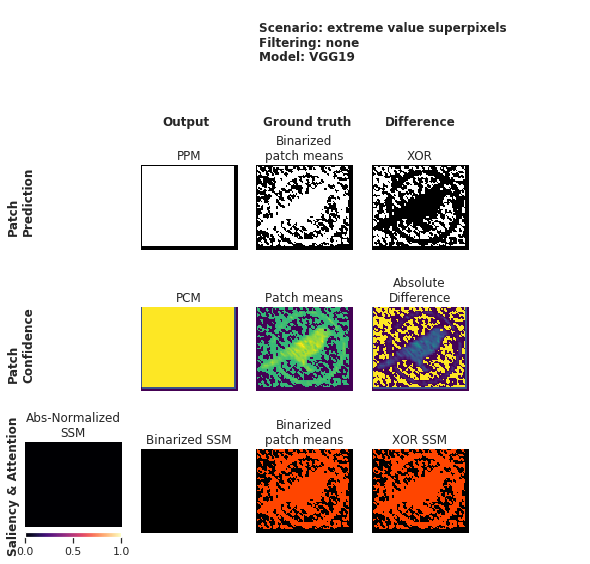

In [23]:
model = "VGG19"
example_1 = "reg69-canary-hot-test_superpixels.npy"
example_0 = "reg70-canary-cold-test_superpixels.npy"
scores = report_card(scenario, model, example_1, example_0, filter_toggle=filtration)

In [24]:
experiment = model +"_"+ scenario +"_"+ filtration +"_"+ labeling
log_performance(scores, experiment, overwrite_flag=True)
df = pd.read_csv("outputs/master_scores.csv")
df.head()

Score CSV file detected!
Score DICT file detected!
Overwrite flag is True... writing to master_scores.csv!
['VGG19_extreme_value_superpixels_none_inheritance', 0.5, 0.75, 0.5, 'topk_majority accuracy = 0.500', 'all_max accuracy = 0.500', 'all_majority accuracy = 0.500', 'all_weighted_majority accuracy = 0.500', 'all_caucus_max accuracy = 0.500', 'all_caucus_majority accuracy = 0.500', 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.75, 0.75, 0.6666666666666667, 0.625, 0.6270833333333334, 0.6059027777777778, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 'Average test ppm_confidence-mae (CI) = 0.224 (0.018)', 'Average test ppm_confidence-ssim (CI) = 0.176 (0.041)', 'Average test ppm_values-dice (CI) = 0.432 (0.087)', 'Average test ppm_values-jaccard (CI) = 0.384 (0.078)', 'Average test ppm_values-overlap (CI) = 0.500 (0.100)', 'Average test ppm_values-sensitivity (CI) = 0.500 (0.100)', 'Average test ppm_values-specificty (CI) = 0.658 (0.051)', 'Average test ppm_values-difference (CI) = 0.463 (0.055)', 'Average test ppm

,experiment,patch_auroc,patch_auprc,patch_ap,acc_topk_maj,acc_all_max,acc_all_maj,acc_all_weight,acc_all_caucus_max,acc_all_caucus_maj,...,sam_overlap,sam_sens,sam_spec,sam_diff,sam_scagcos,sam_mae,sam_f,sam_s,sam_e,sam_ssim
0,VGG_att_extreme_value_pixels_background_inheri...,1.0,1.000000,1.000000,1.0,0.5,0.76,0.5,0.646,0.667,...,0.749 (0.122),0.433 (0.123),0.985 (0.009),0.327 (0.067),0.361 (0.111),31.414 (4.148),0.489 (0.102),0.003 (0.004),0.542 (0.046),0.227 (0.061)
1,VGG19_extreme_value_pixels_background_inheritance,1.0,1.000000,1.000000,1.0,0.5,0.76,0.5,0.646,0.667,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,VGG19_distribution_shifted_pixels_background_i...,0.5,0.750014,0.500028,0.5,0.5,0.50,0.5,0.500,0.500,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,VGG_att_distribution_shifted_pixels_background...,1.0,1.000000,1.000000,1.0,0.5,0.75,0.5,0.688,0.667,...,0.930 (0.068),0.493 (0.114),0.990 (0.005),0.285 (0.066),0.170 (0.068),0.831 (0.112),0.585 (0.098),0.541 (0.016),0.610 (0.045),0.412 (0.054)
4,VGG19_distribution_shifted_pixels_none_inherit...,0.5,0.750000,0.500000,0.5,0.5,0.50,0.5,0.500,0.500,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Test dataset:
{'reg11': 1, 'reg32': 0, 'reg84': 0, 'reg96': 0, 'reg36': 0, 'reg33': 1, 'reg14': 0, 'reg49': 1, 'reg71': 1, 'reg68': 0, 'reg81': 1, 'reg90': 0, 'reg56': 0, 'reg1': 1, 'reg78': 0, 'reg6': 0, 'reg45': 1, 'reg53': 1, 'reg80': 0, 'reg57': 1, 'reg76': 0, 'reg19': 1, 'reg13': 1, 'reg23': 1, 'reg41': 1, 'reg63': 1, 'reg85': 1, 'reg9': 1, 'reg17': 1, 'reg28': 0, 'reg30': 0, 'reg72': 0, 'reg54': 0, 'reg12': 0, 'reg73': 1, 'reg37': 1, 'reg74': 0, 'reg16': 0, 'reg87': 1, 'reg10': 0, 'reg44': 0, 'reg15': 1, 'reg65': 1, 'reg35': 1, 'reg40': 0, 'reg77': 1, 'reg48': 0, 'reg88': 0, 'reg64': 0, 'reg34': 0, 'reg94': 0, 'reg83': 1, 'reg55': 1, 'reg26': 0, 'reg51': 1, 'reg91': 1, 'reg8': 0, 'reg18': 0, 'reg79': 1, 'reg24': 0, 'reg70': 0, 'reg61': 1, 'reg3': 1, 'reg86': 0, 'reg43': 1, 'reg22': 0, 'reg50': 0, 'reg2': 0, 'reg25': 1, 'reg95': 1, 'reg46': 0, 'reg39': 1, 'reg69': 1, 'reg38': 0, 'reg21': 1, 'reg42': 0, 'reg58': 0, 'reg75': 1, 'reg89': 1, 'reg5': 1, 'reg7': 1, 'reg27': 1, 'reg92': 

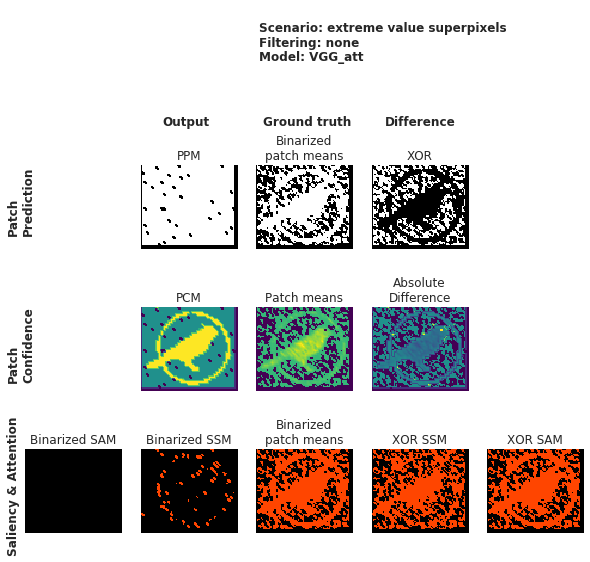

In [25]:
model = "VGG_att"
example_1 = "reg69-canary-hot-test_superpixels.npy"
example_0 = "reg70-canary-cold-test_superpixels.npy"
scores = report_card(scenario, model, example_1, example_0, filter_toggle=filtration)

In [26]:
experiment = model +"_"+ scenario +"_"+ filtration +"_"+ labeling
log_performance(scores, experiment, overwrite_flag=True)
df = pd.read_csv("outputs/master_scores.csv")
df.head()

Score CSV file detected!
Score DICT file detected!
Overwrite flag is True... writing to master_scores.csv!
['VGG_att_extreme_value_superpixels_none_inheritance', 0.8327724687313365, 0.8499709068937741, 0.8499570096250791, 'topk_majority accuracy = 1.000', 'all_max accuracy = 0.500', 'all_majority accuracy = 0.979', 'all_weighted_majority accuracy = 0.500', 'all_caucus_max accuracy = 0.500', 'all_caucus_majority accuracy = 0.896', 1.0, 1.0, 0.888888888888889, 0.852023654513889, 0.7972048611111111, 0.8009138695987654, 1.0, 1.0, 0.9041053897823632, 0.857874791861617, 0.8077396512524739, 0.7954000411185915, 1.0, 1.0, 0.9043947416342151, 0.8582430597806064, 0.8081514019031648, 0.7958040867160692, 'Average test ppm_confidence-mae (CI) = 0.323 (0.010)', 'Average test ppm_confidence-ssim (CI) = 0.329 (0.031)', 'Average test ppm_values-dice (CI) = 0.765 (0.034)', 'Average test ppm_values-jaccard (CI) = 0.645 (0.038)', 'Average test ppm_values-overlap (CI) = 0.941 (0.012)', 'Average test ppm_val

,experiment,patch_auroc,patch_auprc,patch_ap,acc_topk_maj,acc_all_max,acc_all_maj,acc_all_weight,acc_all_caucus_max,acc_all_caucus_maj,...,sam_overlap,sam_sens,sam_spec,sam_diff,sam_scagcos,sam_mae,sam_f,sam_s,sam_e,sam_ssim
0,VGG_att_extreme_value_pixels_background_inheri...,1.0,1.000000,1.000000,1.0,0.5,0.76,0.5,0.646,0.667,...,0.749 (0.122),0.433 (0.123),0.985 (0.009),0.327 (0.067),0.361 (0.111),31.414 (4.148),0.489 (0.102),0.003 (0.004),0.542 (0.046),0.227 (0.061)
1,VGG19_extreme_value_pixels_background_inheritance,1.0,1.000000,1.000000,1.0,0.5,0.76,0.5,0.646,0.667,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,VGG19_distribution_shifted_pixels_background_i...,0.5,0.750014,0.500028,0.5,0.5,0.50,0.5,0.500,0.500,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,VGG_att_distribution_shifted_pixels_background...,1.0,1.000000,1.000000,1.0,0.5,0.75,0.5,0.688,0.667,...,0.930 (0.068),0.493 (0.114),0.990 (0.005),0.285 (0.066),0.170 (0.068),0.831 (0.112),0.585 (0.098),0.541 (0.016),0.610 (0.045),0.412 (0.054)
4,VGG19_distribution_shifted_pixels_none_inherit...,0.5,0.750000,0.500000,0.5,0.5,0.50,0.5,0.500,0.500,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Scenario (e) - Guilty Superpixels (GSP)

### Background-filtered experiments

`Check training labels`

In [29]:
scenario = "guilty_superpixels"
labeling = "inheritance"
print_train_stats(scenario, filter_toggle=filtration)

Train dataset
{'reg13': 0, 'reg60': 1, 'reg12': 1, 'reg55': 0, 'reg79': 0, 'reg35': 0, 'reg90': 1, 'reg36': 1, 'reg84': 1, 'reg75': 0, 'reg29': 0, 'reg65': 0, 'reg2': 1, 'reg70': 1, 'reg86': 1, 'reg30': 1, 'reg57': 0, 'reg22': 1, 'reg54': 1, 'reg20': 1, 'reg3': 0, 'reg40': 1, 'reg17': 0, 'reg82': 1, 'reg83': 0, 'reg59': 0, 'reg66': 1, 'reg52': 1, 'reg56': 1, 'reg46': 1, 'reg33': 0, 'reg63': 0, 'reg50': 1, 'reg78': 1, 'reg51': 0, 'reg93': 0, 'reg31': 0, 'reg67': 0, 'reg42': 1, 'reg43': 0, 'reg73': 0, 'reg25': 0, 'reg4': 1, 'reg69': 0, 'reg38': 1, 'reg8': 1, 'reg81': 0, 'reg47': 0, 'reg85': 0, 'reg68': 1, 'reg44': 1, 'reg58': 1, 'reg71': 0, 'reg18': 1, 'reg77': 0, 'reg7': 0, 'reg48': 1, 'reg92': 1, 'reg62': 1, 'reg10': 1, 'reg91': 0, 'reg80': 1, 'reg74': 1, 'reg89': 0, 'reg1': 0, 'reg23': 0, 'reg45': 0, 'reg14': 1, 'reg15': 0, 'reg87': 0, 'reg64': 1, 'reg9': 0, 'reg28': 1, 'reg6': 1, 'reg11': 0, 'reg88': 1, 'reg96': 1, 'reg76': 1, 'reg41': 0, 'reg49': 0, 'reg19': 0, 'reg94': 1, 'reg27': 

In [30]:
filtration

'none'

`VGG-19 Report Card`

In [31]:
model = "VGG19"
example_1 = "reg70-canary_guilty-hot-test.npy" # "reg2-jerrywest-logodesignlove_guilty-hot-test.npy" 
example_0 =  "reg69-canary-hot-test.npy" # "reg1-jerrywest-logodesignlove-hot-test.npy"
scores = report_card(scenario, model, example_1, example_0, reduce_flag="manual", filter_toggle=filtration)

FileNotFoundError: [Errno 2] No such file or directory: 'outputs/test-controls-guilty_superpixels-96-none-labeldict.obj'

In [ ]:
experiment = model +"_"+ scenario +"_"+ filtration +"_"+ labeling
log_performance(scores, experiment, overwrite_flag=True)
df = pd.read_csv("outputs/master_scores.csv")
df.head()

`VGG-Att Report Card`

In [ ]:
model = "VGG_att"
example_1 = "reg70-canary_guilty-hot-test.npy" # "reg2-jerrywest-logodesignlove_guilty-hot-test.npy" 
example_0 = "reg69-canary-hot-test.npy" # "reg1-jerrywest-logodesignlove-hot-test.npy"
scores = report_card(scenario, model, example_1, example_0, reduce_flag="manual", filter_toggle=filtration)

In [ ]:
experiment = model +"_"+ scenario +"_"+ filtration +"_"+ labeling
log_performance(scores, experiment, overwrite_flag=True)
df = pd.read_csv("outputs/master_scores.csv")
df.head()

# Scenario (f) - Fractal Morphologies (FM)

### Background-filtered experiments

`Check training labels`

In [7]:
scenario = "fractal_morphologies"
labeling = "inheritance"
print_train_stats(scenario, filter_toggle=filtration)

Train dataset
{'reg32': 1, 'reg13': 0, 'reg10': 1, 'reg64': 1, 'reg16': 1, 'reg55': 0, 'reg79': 0, 'reg35': 0, 'reg6': 1, 'reg22': 1, 'reg75': 0, 'reg29': 0, 'reg65': 0, 'reg42': 1, 'reg96': 1, 'reg8': 1, 'reg57': 0, 'reg74': 1, 'reg3': 0, 'reg17': 0, 'reg83': 0, 'reg78': 1, 'reg66': 1, 'reg59': 0, 'reg48': 1, 'reg2': 1, 'reg33': 0, 'reg63': 0, 'reg51': 0, 'reg93': 0, 'reg31': 0, 'reg90': 1, 'reg67': 0, 'reg92': 1, 'reg43': 0, 'reg73': 0, 'reg28': 1, 'reg25': 0, 'reg84': 1, 'reg69': 0, 'reg70': 1, 'reg24': 1, 'reg81': 0, 'reg72': 1, 'reg47': 0, 'reg85': 0, 'reg71': 0, 'reg12': 1, 'reg77': 0, 'reg86': 1, 'reg30': 1, 'reg62': 1, 'reg7': 0, 'reg91': 0, 'reg94': 1, 'reg89': 0, 'reg60': 1, 'reg1': 0, 'reg23': 0, 'reg52': 1, 'reg45': 0, 'reg15': 0, 'reg87': 0, 'reg68': 1, 'reg50': 1, 'reg9': 0, 'reg11': 0, 'reg58': 1, 'reg76': 1, 'reg20': 1, 'reg41': 0, 'reg49': 0, 'reg19': 0, 'reg46': 1, 'reg27': 0, 'reg5': 0, 'reg40': 1, 'reg18': 1, 'reg54': 1, 'reg56': 1, 'reg39': 0, 'reg14': 1, 'reg37': 

`VGG-19 Report Card`

Test dataset:
{'reg3': 0, 'reg45': 0, 'reg31': 0, 'reg66': 1, 'reg30': 1, 'reg92': 1, 'reg79': 0, 'reg85': 0, 'reg65': 0, 'reg9': 0, 'reg73': 0, 'reg27': 0, 'reg38': 1, 'reg91': 0, 'reg63': 0, 'reg77': 0, 'reg34': 1, 'reg81': 0, 'reg21': 0, 'reg22': 1, 'reg20': 1, 'reg2': 1, 'reg80': 1, 'reg24': 1, 'reg35': 0, 'reg42': 1, 'reg56': 1, 'reg23': 0, 'reg50': 1, 'reg49': 0, 'reg94': 1, 'reg70': 1, 'reg14': 1, 'reg83': 0, 'reg96': 1, 'reg17': 0, 'reg61': 0, 'reg54': 1, 'reg90': 1, 'reg46': 1, 'reg5': 0, 'reg19': 0, 'reg78': 1, 'reg67': 0, 'reg84': 1, 'reg12': 1, 'reg32': 1, 'reg10': 1, 'reg55': 0, 'reg28': 1, 'reg57': 0, 'reg59': 0, 'reg52': 1, 'reg75': 0, 'reg64': 1, 'reg8': 1, 'reg95': 0, 'reg15': 0, 'reg44': 1, 'reg48': 1, 'reg58': 1, 'reg87': 0, 'reg13': 0, 'reg47': 0, 'reg36': 1, 'reg71': 0, 'reg62': 1, 'reg40': 1, 'reg74': 1, 'reg39': 0, 'reg4': 1, 'reg25': 0, 'reg93': 0, 'reg89': 0, 'reg16': 1, 'reg76': 1, 'reg18': 1, 'reg6': 1, 'reg33': 0, 'reg7': 0, 'reg29': 0, 'reg1': 0, 'reg86': 1

/home/groups/plevriti/gautam/codex_analysis/codex-analysis/code/saliency.py:664: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  score = rule(a, b)


	 33 reg83 label= 0
	 34 reg96 label= 1
ssm/sam dice
ssm/sam jaccard
ssm/sam overlap
ssm/sam sensitivity
ssm/sam specificty
ssm/sam difference
ssm/sam scagnostics_cos
ssm/sam mae
ssm/sam f-measure
ssm/sam s-measure
ssm/sam e-measure
ssm/sam ssim
	 35 reg17 label= 0
	 36 reg61 label= 0
	 37 reg54 label= 1
ssm/sam dice
ssm/sam jaccard
ssm/sam overlap
ssm/sam sensitivity
ssm/sam specificty
ssm/sam difference
ssm/sam scagnostics_cos
ssm/sam mae
ssm/sam f-measure
ssm/sam s-measure
ssm/sam e-measure
ssm/sam ssim
	 38 reg90 label= 1
ssm/sam dice
ssm/sam jaccard
ssm/sam overlap
ssm/sam sensitivity
ssm/sam specificty
ssm/sam difference
ssm/sam scagnostics_cos
ssm/sam mae
ssm/sam f-measure
ssm/sam s-measure
ssm/sam e-measure
ssm/sam ssim
	 39 reg46 label= 1
ssm/sam dice
ssm/sam jaccard
ssm/sam overlap
ssm/sam sensitivity
ssm/sam specificty
ssm/sam difference
ssm/sam scagnostics_cos
ssm/sam mae
ssm/sam f-measure
ssm/sam s-measure
ssm/sam e-measure
ssm/sam ssim
	 40 reg5 label= 0
	Completed analys

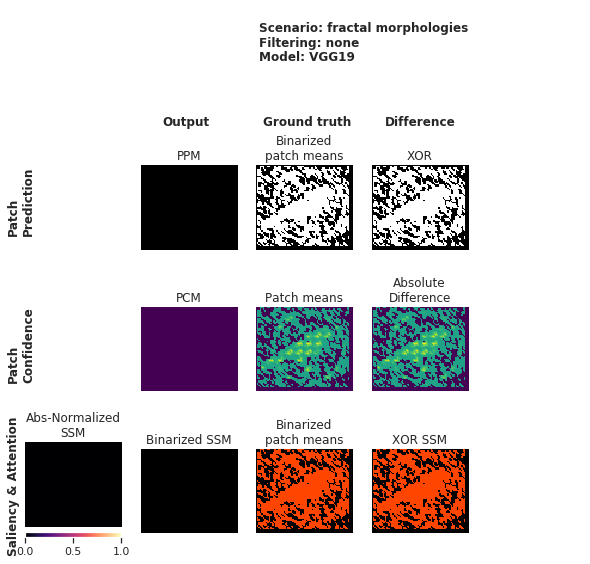

In [13]:
model = "VGG19"
example_1 = "reg70-canary-hot-test_fractal.npy" 
example_0 = "reg69-canary-hot-test.npy"
scores = report_card(scenario, model, example_1, example_0, filter_toggle=filtration)

In [14]:
experiment = model +"_"+ scenario +"_"+ filtration +"_"+ labeling
log_performance(scores, experiment, overwrite_flag=True)
df = pd.read_csv("outputs/master_scores.csv")
df.head()

Score CSV file detected!
Score DICT file detected!
Overwrite flag is True... writing to master_scores.csv!
['VGG19_fractal_morphologies_none_inheritance', 0.5, 0.75, 0.5, 'topk_majority accuracy = 0.500', 'all_max accuracy = 0.500', 'all_majority accuracy = 0.500', 'all_weighted_majority accuracy = 0.500', 'all_caucus_max accuracy = 0.500', 'all_caucus_majority accuracy = 0.500', 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.75, 0.625, 0.5833333333333334, 0.5625, 0.55, 0.5416666666666667, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 'Average test ppm_confidence-mae (CI) = 0.353 (0.023)', 'Average test ppm_confidence-ssim (CI) = 0.160 (0.038)', 'Average test ppm_values-dice (CI) = 0.426 (0.086)', 'Average test ppm_values-jaccard (CI) = 0.374 (0.076)', 'Average test ppm_values-overlap (CI) = 0.500 (0.100)', 'Average test ppm_values-sensitivity (CI) = 0.500 (0.100)', 'Average test ppm_values-specificty (CI) = 0.627 (0.076)', 'Average test ppm_values-difference (CI) = 0.456 (0.048)', 'Average test ppm_values-scagnosti

,experiment,patch_auroc,patch_auprc,patch_ap,acc_topk_maj,acc_all_max,acc_all_maj,acc_all_weight,acc_all_caucus_max,acc_all_caucus_maj,...,sam_overlap,sam_sens,sam_spec,sam_diff,sam_scagcos,sam_mae,sam_f,sam_s,sam_e,sam_ssim
0,VGG_att_extreme_value_pixels_background_inheri...,1.0,1.000000,1.000000,1.0,0.5,0.76,0.5,0.646,0.667,...,0.749 (0.122),0.433 (0.123),0.985 (0.009),0.327 (0.067),0.361 (0.111),31.414 (4.148),0.489 (0.102),0.003 (0.004),0.542 (0.046),0.227 (0.061)
1,VGG19_extreme_value_pixels_background_inheritance,1.0,1.000000,1.000000,1.0,0.5,0.76,0.5,0.646,0.667,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,VGG19_distribution_shifted_pixels_background_i...,0.5,0.750014,0.500028,0.5,0.5,0.50,0.5,0.500,0.500,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,VGG_att_distribution_shifted_pixels_background...,1.0,1.000000,1.000000,1.0,0.5,0.75,0.5,0.688,0.667,...,0.930 (0.068),0.493 (0.114),0.990 (0.005),0.285 (0.066),0.170 (0.068),0.831 (0.112),0.585 (0.098),0.541 (0.016),0.610 (0.045),0.412 (0.054)
4,VGG19_distribution_shifted_pixels_none_inherit...,0.5,0.750000,0.500000,0.5,0.5,0.50,0.5,0.500,0.500,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


`VGG-Att Report Card`

Test dataset:
{'reg3': 0, 'reg45': 0, 'reg31': 0, 'reg66': 1, 'reg30': 1, 'reg92': 1, 'reg79': 0, 'reg85': 0, 'reg65': 0, 'reg9': 0, 'reg73': 0, 'reg27': 0, 'reg38': 1, 'reg91': 0, 'reg63': 0, 'reg77': 0, 'reg34': 1, 'reg81': 0, 'reg21': 0, 'reg22': 1, 'reg20': 1, 'reg2': 1, 'reg80': 1, 'reg24': 1, 'reg35': 0, 'reg42': 1, 'reg56': 1, 'reg23': 0, 'reg50': 1, 'reg49': 0, 'reg94': 1, 'reg70': 1, 'reg14': 1, 'reg83': 0, 'reg96': 1, 'reg17': 0, 'reg61': 0, 'reg54': 1, 'reg90': 1, 'reg46': 1, 'reg5': 0, 'reg19': 0, 'reg78': 1, 'reg67': 0, 'reg84': 1, 'reg12': 1, 'reg32': 1, 'reg10': 1, 'reg55': 0, 'reg28': 1, 'reg57': 0, 'reg59': 0, 'reg52': 1, 'reg75': 0, 'reg64': 1, 'reg8': 1, 'reg95': 0, 'reg15': 0, 'reg44': 1, 'reg48': 1, 'reg58': 1, 'reg87': 0, 'reg13': 0, 'reg47': 0, 'reg36': 1, 'reg71': 0, 'reg62': 1, 'reg40': 1, 'reg74': 1, 'reg39': 0, 'reg4': 1, 'reg25': 0, 'reg93': 0, 'reg89': 0, 'reg16': 1, 'reg76': 1, 'reg18': 1, 'reg6': 1, 'reg33': 0, 'reg7': 0, 'reg29': 0, 'reg1': 0, 'reg86': 1

/home/groups/plevriti/gautam/codex_analysis/codex-analysis/code/saliency.py:666: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  score = rule(a, b)


ssm/sam jaccard
ssm/sam overlap
ssm/sam sensitivity
ssm/sam specificty
ssm/sam difference
ssm/sam scagnostics_cos
ssm/sam mae
ssm/sam f-measure
ssm/sam s-measure
ssm/sam e-measure
ssm/sam ssim
	 5 reg92 label= 1
ssm/sam dice
ssm/sam jaccard
ssm/sam overlap
ssm/sam sensitivity
ssm/sam specificty
ssm/sam difference
ssm/sam scagnostics_cos
ssm/sam mae
ssm/sam f-measure
ssm/sam s-measure
ssm/sam e-measure
ssm/sam ssim
	 6 reg79 label= 0
	 7 reg85 label= 0
	 8 reg65 label= 0
	 9 reg9 label= 0
	 10 reg73 label= 0
	Completed analyses for 10 control images
	 11 reg27 label= 0
	 12 reg38 label= 1
ssm/sam dice
ssm/sam jaccard
ssm/sam overlap
ssm/sam sensitivity
ssm/sam specificty
ssm/sam difference
ssm/sam scagnostics_cos
ssm/sam mae
ssm/sam f-measure
ssm/sam s-measure
ssm/sam e-measure
ssm/sam ssim
	 13 reg91 label= 0
	 14 reg63 label= 0
	 15 reg77 label= 0
	 16 reg34 label= 1
ssm/sam dice
ssm/sam jaccard
ssm/sam overlap
ssm/sam sensitivity
ssm/sam specificty
ssm/sam difference
ssm/sam scagnost

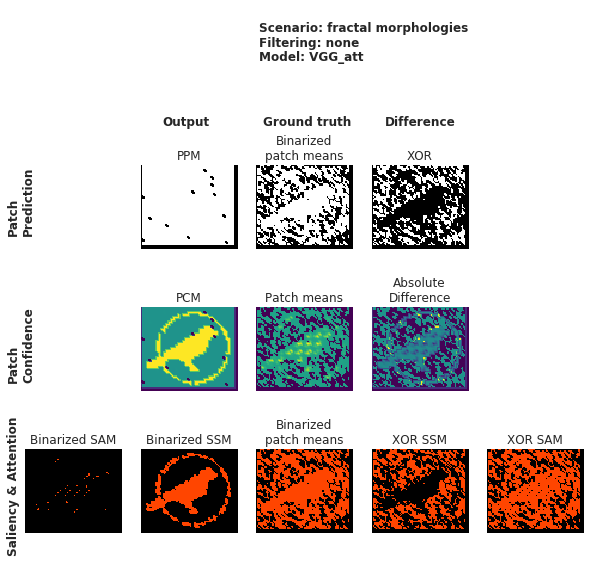

In [8]:
model = "VGG_att"
example_1 = "reg70-canary-hot-test_fractal.npy" 
example_0 = "reg69-canary-hot-test.npy"
scores = report_card(scenario, model, example_1, example_0, filter_toggle=filtration, reduce_flag="manual")

In [9]:
experiment = model +"_"+ scenario +"_"+ filtration +"_"+ labeling
log_performance(scores, experiment, overwrite_flag=True)
df = pd.read_csv("outputs/master_scores.csv")
df.head()

Score CSV file detected!
Score DICT file detected!
Overwrite flag is True... writing to master_scores.csv!
['VGG_att_fractal_morphologies_none_inheritance', 0.8560965674065251, 0.8692522030748466, 0.8692383156630934, 'topk_majority accuracy = 1.000', 'all_max accuracy = 0.500', 'all_majority accuracy = 0.979', 'all_weighted_majority accuracy = 0.500', 'all_caucus_max accuracy = 0.500', 'all_caucus_majority accuracy = 0.917', 1.0, 1.0, 0.888888888888889, 0.8582085503472222, 0.8163888888888888, 0.8230492862654322, 1.0, 1.0, 0.9041053897823632, 0.8614281446770273, 0.8225593933664832, 0.813653911268521, 1.0, 1.0, 0.9043947416342151, 0.8617918141115328, 0.8229481316320766, 0.8140324492309147, 'Average test ppm_confidence-mae (CI) = 0.213 (0.013)', 'Average test ppm_confidence-ssim (CI) = 0.425 (0.040)', 'Average test ppm_values-dice (CI) = 0.802 (0.029)', 'Average test ppm_values-jaccard (CI) = 0.689 (0.034)', 'Average test ppm_values-overlap (CI) = 0.939 (0.009)', 'Average test ppm_values-

,experiment,patch_auroc,patch_auprc,patch_ap,acc_topk_maj,acc_all_max,acc_all_maj,acc_all_weight,acc_all_caucus_max,acc_all_caucus_maj,...,sam_overlap,sam_sens,sam_spec,sam_diff,sam_scagcos,sam_mae,sam_f,sam_s,sam_e,sam_ssim
0,VGG_att_extreme_value_pixels_background_inheri...,1.0,1.000000,1.000000,1.0,0.5,0.76,0.5,0.646,0.667,...,0.749 (0.122),0.433 (0.123),0.985 (0.009),0.327 (0.067),0.361 (0.111),31.414 (4.148),0.489 (0.102),0.003 (0.004),0.542 (0.046),0.227 (0.061)
1,VGG19_extreme_value_pixels_background_inheritance,1.0,1.000000,1.000000,1.0,0.5,0.76,0.5,0.646,0.667,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,VGG19_distribution_shifted_pixels_background_i...,0.5,0.750014,0.500028,0.5,0.5,0.50,0.5,0.500,0.500,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,VGG_att_distribution_shifted_pixels_background...,1.0,1.000000,1.000000,1.0,0.5,0.75,0.5,0.688,0.667,...,0.930 (0.068),0.493 (0.114),0.990 (0.005),0.285 (0.066),0.170 (0.068),0.831 (0.112),0.585 (0.098),0.541 (0.016),0.610 (0.045),0.412 (0.054)
4,VGG19_distribution_shifted_pixels_none_inherit...,0.5,0.750000,0.500000,0.5,0.5,0.50,0.5,0.500,0.500,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# MISO-2 analysis

In [12]:
import pickle
import utils
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from scipy.signal import medfilt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision

from dataloader import DataLoader
from train import Flatten

from utils import serialize, deserialize, count_files #image_patch_summary, image_patch_pred_map, plot_roc_prc # should probably move serialize and de- to utils

In [13]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
sns.set()
%reload_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
USE_GPU = False
dtype = torch.float32    

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [15]:
patch_root = "/oak/stanford/groups/paragm/gautam/syncontrols/patches/1-channel"
patch_tail = "224-patchsize/background-filtered/train"
figure_path = "figs" # make sure you create a "figs" folder\
ps=224
filtration="none"

In [16]:
from analysis import log_performance, print_train_stats, report_card

In [17]:
scenario = "morphological_differences_superpixels"
labeling = "inheritance"
print_train_stats(scenario, filter_toggle=filtration, patch_size=ps)

Train dataset
{'S11100006-P399-subject408': 1, 'S11100003-P195-subject332': 1, 'S11100006-P139-subject181': 0, 'S11100006-P287-subject96': 0, 'S11100003-P451-subject239': 0, 'S11100003-P023-subject264': 1, 'S11100003-P271-subject306': 0, 'S11100006-P119-subject51': 0, 'S11100006-P331-subject258': 0, 'S11100006-P223-subject245': 0, 'S11100003-P339-subject236': 1, 'S11100006-P175-subject415': 0, 'S11100003-P119-subject51': 0, 'S11100003-P175-subject415': 0, 'S11100006-P143-subject266': 0, 'S11100006-P191-subject344': 0, 'S11100003-P439-subject272': 1, 'S11100006-P339-subject236': 1, 'S11100006-P367-subject259': 0, 'S11100006-P115-subject38': 1, 'S11100003-P391-subject337': 0, 'S11100003-P207-subject291': 0, 'S11100006-P347-subject214': 1, 'S11100003-P039-subject313': 1, 'S11100006-P171-subject404': 1, 'S11100006-P231-subject80': 0, 'S11100006-P199-subject318': 1, 'S11100003-P287-subject96': 0, 'S11100006-P167-subject343': 1, 'S11100006-P007-subject15': 1, 'S11100003-P111-subject232': 1, 

## VGG-19

S11100003_P143_subject266
S11100006_P235_subject212
S11100003_P355_subject153
S11100003_P203_subject302
S11100006_P259_subject172
S11100006_P363_subject248
S11100003_P115_subject38
S11100003_P367_subject259
S11100003_P019_subject64
S11100006_P359_subject163
S11100006_P023_subject264
S11100003_P171_subject404
S11100003_P411_subject410
S11100003_P331_subject258
S11100006_P491_subject297
S11100006_P391_subject337
S11100006_P447_subject249
S11100006_P503_subject339
S11100006_P311_subject320
S11100003_P283_subject345
S11100006_P423_subject322
S11100003_P279_subject333
S11100003_P235_subject212
S11100003_P311_subject320
S11100003_P263_subject279
S11100003_P167_subject343
S11100006_P127_subject222
S11100003_P155_subject301
S11100003_P407_subject420
S11100003_P083_subject315
S11100006_P451_subject239
S11100006_P131_subject233
S11100003_P079_subject92
S11100003_P127_subject222
S11100006_P351_subject215
S11100003_P179_subject429
S11100003_P143_subject266
S11100006_P235_subject212
S11100003_P355_

/home/groups/plevriti/gautam/codex_analysis/codex-analysis/code/saliency.py:664: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  score = rule(a, b)


S11100006_P359_subject163
	 9 S11100006-P359-subject163 label= 0
S11100006_P023_subject264
	 10 S11100006-P023-subject264 label= 1
	Completed analyses for 10 control images
ssm/sam dice
ssm/sam jaccard
ssm/sam overlap
ssm/sam sensitivity
ssm/sam specificty
ssm/sam difference
ssm/sam scagnostics_cos
ssm/sam mae
ssm/sam f-measure
ssm/sam s-measure
ssm/sam e-measure
ssm/sam ssim
S11100003_P171_subject404
	 11 S11100003-P171-subject404 label= 1
ssm/sam dice
ssm/sam jaccard
ssm/sam overlap
ssm/sam sensitivity
ssm/sam specificty
ssm/sam difference
ssm/sam scagnostics_cos
ssm/sam mae
ssm/sam f-measure
ssm/sam s-measure
ssm/sam e-measure
ssm/sam ssim
S11100003_P411_subject410
	 12 S11100003-P411-subject410 label= 1
ssm/sam dice
ssm/sam jaccard
ssm/sam overlap
ssm/sam sensitivity
ssm/sam specificty
ssm/sam difference
ssm/sam scagnostics_cos
ssm/sam mae
ssm/sam f-measure
ssm/sam s-measure
ssm/sam e-measure
ssm/sam ssim
S11100003_P331_subject258
	 13 S11100003-P331-subject258 label= 0
S11100006_P

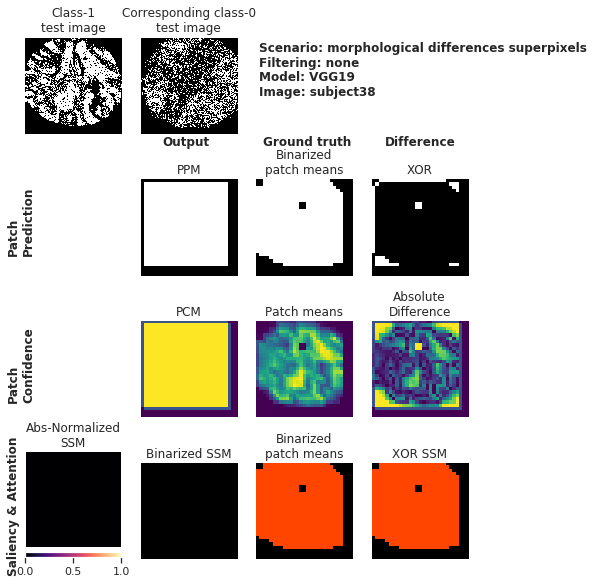

In [18]:
model = "VGG19"
example_1 = "S11100003_P115_subject38_stitched_labelS.npy"  #"S11100003_P079_subject92_stitched_labelS.npy" 
example_0 = "S11100003_P143_subject266_stitched_labelA.npy" 
scores = report_card(scenario, model, example_1, example_0, reduce_flag="manual", filter_toggle=filtration, patch_size=224)

In [19]:
experiment = model +"_"+ scenario +"_"+ filtration +"_"+ labeling
log_performance(scores, experiment, overwrite_flag=True)
df = pd.read_csv("outputs/master_scores.csv")
df.head()

Score CSV file detected!
Score DICT file detected!
Overwrite flag is True... writing to master_scores.csv!
['VGG19_morphological_differences_superpixels_none_inheritance', 0.5, 0.75, 0.5, 'topk_majority accuracy = 0.500', 'all_max accuracy = 0.500', 'all_majority accuracy = 0.500', 'all_weighted_majority accuracy = 0.500', 'all_caucus_max accuracy = 0.500', 'all_caucus_majority accuracy = 0.500', 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.75, 0.75, 0.6666666666666667, 0.625, 0.6499999999999999, 0.625, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 'Average test ppm_confidence-mae (CI) = 0.250 (0.032)', 'Average test ppm_confidence-ssim (CI) = 0.159 (0.052)', 'Average test ppm_values-dice (CI) = 0.476 (0.156)', 'Average test ppm_values-jaccard (CI) = 0.455 (0.149)', 'Average test ppm_values-overlap (CI) = 0.483 (0.158)', 'Average test ppm_values-sensitivity (CI) = 0.471 (0.154)', 'Average test ppm_values-specificty (CI) = 0.823 (0.024)', 'Average test ppm_values-difference (CI) = 0.440 (0.121)', 'Average test ppm_

,experiment,patch_auroc,patch_auprc,patch_ap,acc_topk_maj,acc_all_max,acc_all_maj,acc_all_weight,acc_all_caucus_max,acc_all_caucus_maj,...,sam_overlap,sam_sens,sam_spec,sam_diff,sam_scagcos,sam_mae,sam_f,sam_s,sam_e,sam_ssim
0,VGG_att_extreme_value_pixels_background_inheri...,1.0,1.000000,1.000000,1.0,0.5,0.76,0.5,0.646,0.667,...,0.749 (0.122),0.433 (0.123),0.985 (0.009),0.327 (0.067),0.361 (0.111),31.414 (4.148),0.489 (0.102),0.003 (0.004),0.542 (0.046),0.227 (0.061)
1,VGG19_extreme_value_pixels_background_inheritance,1.0,1.000000,1.000000,1.0,0.5,0.76,0.5,0.646,0.667,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,VGG19_distribution_shifted_pixels_background_i...,0.5,0.750014,0.500028,0.5,0.5,0.50,0.5,0.500,0.500,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,VGG_att_distribution_shifted_pixels_background...,1.0,1.000000,1.000000,1.0,0.5,0.75,0.5,0.688,0.667,...,0.930 (0.068),0.493 (0.114),0.990 (0.005),0.285 (0.066),0.170 (0.068),0.831 (0.112),0.585 (0.098),0.541 (0.016),0.610 (0.045),0.412 (0.054)
4,VGG19_distribution_shifted_pixels_none_inherit...,0.5,0.750000,0.500000,0.5,0.5,0.50,0.5,0.500,0.500,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## VGG-Att

S11100003_P143_subject266
S11100006_P235_subject212
S11100003_P355_subject153
S11100003_P203_subject302
S11100006_P259_subject172
S11100006_P363_subject248
S11100003_P115_subject38
S11100003_P367_subject259
S11100003_P019_subject64
S11100006_P359_subject163
S11100006_P023_subject264
S11100003_P171_subject404
S11100003_P411_subject410
S11100003_P331_subject258
S11100006_P491_subject297
S11100006_P391_subject337
S11100006_P447_subject249
S11100006_P503_subject339
S11100006_P311_subject320
S11100003_P283_subject345
S11100006_P423_subject322
S11100003_P279_subject333
S11100003_P235_subject212
S11100003_P311_subject320
S11100003_P263_subject279
S11100003_P167_subject343
S11100006_P127_subject222
S11100003_P155_subject301
S11100003_P407_subject420
S11100003_P083_subject315
S11100006_P451_subject239
S11100006_P131_subject233
S11100003_P079_subject92
S11100003_P127_subject222
S11100006_P351_subject215
S11100003_P179_subject429
S11100003_P143_subject266
S11100006_P235_subject212
S11100003_P355_

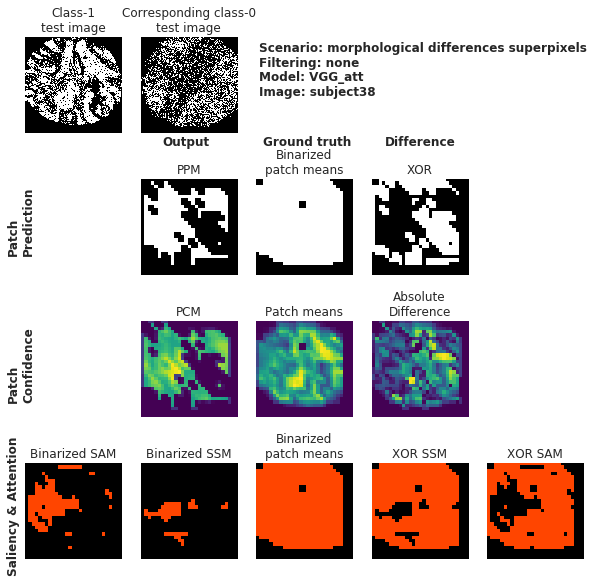

In [20]:
model = "VGG_att"
example_1 = "S11100003_P115_subject38_stitched_labelS.npy"  #"S11100003_P079_subject92_stitched_labelS.npy" 
example_0 = "S11100003_P143_subject266_stitched_labelA.npy"
scores = report_card(scenario, model, example_1, example_0, reduce_flag="manual", filter_toggle=filtration, patch_size=224)

In [21]:
experiment = model +"_"+ scenario +"_"+ filtration +"_"+ labeling
log_performance(scores, experiment, overwrite_flag=True)
df = pd.read_csv("outputs/master_scores.csv")
df.head()

Score CSV file detected!
Score DICT file detected!
Overwrite flag is True... writing to master_scores.csv!
['VGG_att_morphological_differences_superpixels_none_inheritance', 0.5387708180152423, 0.5607061501059296, 0.5606466486849335, 'topk_majority accuracy = 0.639', 'all_max accuracy = 0.500', 'all_majority accuracy = 0.500', 'all_weighted_majority accuracy = 0.500', 'all_caucus_max accuracy = 0.500', 'all_caucus_majority accuracy = 0.500', 0.6882716049382716, 0.5632716049382717, 0.5493827160493827, 0.5381944444444444, 0.5270370370370371, 0.5223765432098766, 0.7378928884518292, 0.6013488156553203, 0.5744025747661411, 0.5589217512989648, 0.544905462755923, 0.5381045618972975, 0.7458106111485885, 0.607805334738892, 0.57964368095784, 0.5633515692718103, 0.5487633676776275, 0.5415306048568569, 'Average test ppm_confidence-mae (CI) = 0.292 (0.017)', 'Average test ppm_confidence-ssim (CI) = 0.073 (0.032)', 'Average test ppm_values-dice (CI) = 0.505 (0.056)', 'Average test ppm_values-jaccard

,experiment,patch_auroc,patch_auprc,patch_ap,acc_topk_maj,acc_all_max,acc_all_maj,acc_all_weight,acc_all_caucus_max,acc_all_caucus_maj,...,sam_overlap,sam_sens,sam_spec,sam_diff,sam_scagcos,sam_mae,sam_f,sam_s,sam_e,sam_ssim
0,VGG_att_extreme_value_pixels_background_inheri...,1.0,1.000000,1.000000,1.0,0.5,0.76,0.5,0.646,0.667,...,0.749 (0.122),0.433 (0.123),0.985 (0.009),0.327 (0.067),0.361 (0.111),31.414 (4.148),0.489 (0.102),0.003 (0.004),0.542 (0.046),0.227 (0.061)
1,VGG19_extreme_value_pixels_background_inheritance,1.0,1.000000,1.000000,1.0,0.5,0.76,0.5,0.646,0.667,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,VGG19_distribution_shifted_pixels_background_i...,0.5,0.750014,0.500028,0.5,0.5,0.50,0.5,0.500,0.500,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,VGG_att_distribution_shifted_pixels_background...,1.0,1.000000,1.000000,1.0,0.5,0.75,0.5,0.688,0.667,...,0.930 (0.068),0.493 (0.114),0.990 (0.005),0.285 (0.066),0.170 (0.068),0.831 (0.112),0.585 (0.098),0.541 (0.016),0.610 (0.045),0.412 (0.054)
4,VGG19_distribution_shifted_pixels_none_inherit...,0.5,0.750000,0.500000,0.5,0.5,0.50,0.5,0.500,0.500,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
